# Abstract

The problem chosen is from Kaggle and its a **Multi class image classification problem**. 

The Dataset for this problem has been taken from kaggle - [Intel Image Classification
Image Scene Classification of Multiclass](https://www.kaggle.com/puneet6060/intel-image-classification)

This Data contains around **25000** **images** of size 150x150 distributed under 6 categories.



```

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

```


The Train, Test and Prediction data is separated in each zip files. There are around **14000** images in **Train**, **3000** in **Test** and **7000** in **Prediction**.

For this problem the Convolution Neural Network has been built from scratch using Pytorch 🔦 and computations for all the model runs have been performed on the Discovery Cluster.


In due course of the tweaking different parameters of the model like activation function, cost function, gradient estimation, network architecture and weight initializations it was observed that these changes have an impact on the accuracy and loss related to the model. The plots for the same taken from tensorboard corroborate the same.

**Acknowledgement**

This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

### 1.1 Importing necessary libraries

In [34]:
import os
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# from resources.plotcm import plot_confusion_matrix
import pandas as pd
import glob
from PIL import Image
from io import open
from tqdm import tqdm
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
from itertools import product
import pathlib
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu102
0.11.1+cu102


### 1.2 Loading the dataset source 📁

We can get a glance at the GPU in use and Torch support with the following snippets of code:

In [3]:
!nvidia-smi

Fri Dec 10 23:31:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   54C    P0    75W / 149W |      0MiB / 11441MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1.3 Dataset: Pre-Processing Images 📸

Reference - [Pytorch - TorchVision Transforms](https://pytorch.org/vision/stable/transforms.html)

In order to get a better performing model we will employ standard image pre-processing techniques such as - 

 

*   Resize the Image ✅
*   Use Random Horizontal Flip ✅
*   Use ToTensor to convert image/numpy nd array to torch float tensor ✅
*   Use Normalize function in Pytorch transforms(Image Standardization) - Normalize each channel of Input Tensor ✅



In [5]:
# Image Pre-processing/Augmentation using Pytorch inbuilt transforms
# Normalize -> 2x3 matrix -> col is RGB channel and row is mean, deviation
# Normalize - Convert 0-1 to  [-1,1], mean and std for 3 channel is 0.5 -> formula = (x-mean)/std
transformer = transforms.Compose([
                                  transforms.Resize((150,150)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(), # 0-255 to 0-1 , numpy to tensor
                                  transforms.Normalize([0.5,0.5,0.5],
                                                       [0.5,0.5,0.5]) 
]) 

### 1.4 Loading the Dataset ⚒

In dealing with CNN problems and datasets, pytorch dataloader helps us to load the data in batches so that the GPU is not overloaded.

Reference - [torchvision ImageFolder](https://pytorch.org/vision/0.8/datasets.html#imagefolder)

In [6]:
# Paths for train and test
train_path = '/home/zutshi.k/datasets/seg_train/seg_train'
test_path = '/home/zutshi.k/datasets/seg_test/seg_test'

# train_loader = DataLoader(
#     torchvision.datasets.ImageFolder(train_path, transform=transformer),
#     batch_size=256, shuffle = True
# )
train_set = torchvision.datasets.ImageFolder(train_path, transform=transformer)
#Dataloader
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transformer),
    batch_size=256, shuffle = True
)

In [7]:
initial_count = 0
for path in pathlib.Path(".").iterdir():
    if path.is_file():
        initial_count += 1

print(initial_count)

len(os.listdir(train_path))

11


6

In [8]:
#categories
root = pathlib.Path(train_path)
print(root.iterdir())
classes = sorted(j.name.split('/')[-1] for j in root.iterdir())
print(classes)

<generator object Path.iterdir at 0x2b2b7fefb650>
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### 1.5 Peek at the Dataset and Visualize 📊

What we can see from the below EDAs - 

- The Train and Test Datasets have almost same counts of images per category.
- From the Pie plots we can see that the dataset is fairly distributed among the Six classes of - 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'

In [9]:
dictData_train = {}
dictData_test = {}
for i in classes:
  if i not in dictData_train:
    dictData_train[i] = len(os.listdir(train_path+'/'+i))
  else:
    dictData_train[i]+=1

for i in classes:
  if i not in dictData_test:
    dictData_test[i] = len(os.listdir(test_path+'/'+i))
  else:
    dictData_test[i]+=1

print(dictData_train)
print(dictData_test)

{'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}
{'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


<BarContainer object of 6 artists>

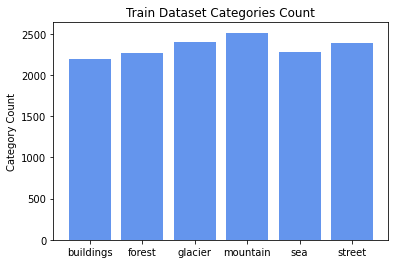

In [10]:
keys = dictData_train.keys()
values = dictData_train.values()
plt.title('Train Dataset Categories Count')
plt.ylabel('Category Count')
plt.bar(keys, values, color='cornflowerblue')

<BarContainer object of 6 artists>

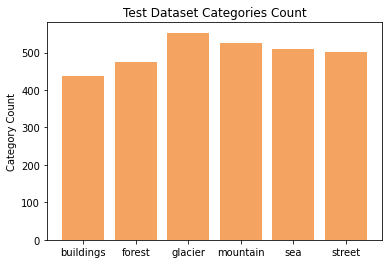

In [11]:
keys = dictData_test.keys()
values = dictData_test.values()
plt.title('Test Dataset Categories Count')
plt.ylabel('Category Count')
plt.bar(keys, values, color = 'sandybrown')

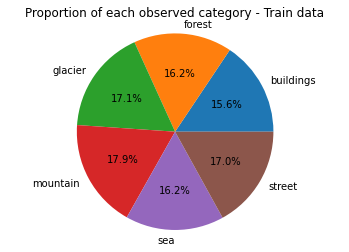

In [12]:
plt.pie(dictData_train.values(),
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=dictData_train.keys(),
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category - Train data')
plt.show()

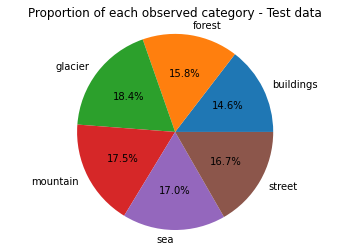

In [13]:
plt.pie(dictData_test.values(),
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=dictData_test.keys(),
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category - Test data')
plt.show()

### 2.1 Create Convolution Neural Network(CNN) using different layers & ReLU ⚙

Here the Activation function used is Rectified Linear (ReLU)

In [1]:
#CNN network

class ConvNet_RELU(nn.Module):
      def __init__(self, num_classes=6):
        super(ConvNet_RELU,self).__init__()

        # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
        # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,12,150,150)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        #Shape -> (256,12,150,150)
        self.relu1 = nn.ReLU()
        #Shape -> (256,12,150,150)
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Reduce the image size by factor of 2
        #Shape -> (256,12, 75,75)


        # 2nd Layer


        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,12,75,75)
        self.relu2 = nn.ReLU()
        #Shape -> (256,20,75,75)


        # 3rd Layer


        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,32,75,75)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        #Shape -> (256,32,75,75)
        self.relu3 = nn.ReLU()
        #Shape -> (256,32,75,75) 

        self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)

# Feed forward function
  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.relu2(output)

    output = self.conv3(output)
    output = self.bn2(output)
    output = self.relu3(output)

    # the output will be in matric form of shape (256,32,75,75)
    # in order to feed it to fully connected layer output needs to be reshaped

    output = output.view(-1,32*75*75)
    output = self.fullyConnected(output)

    return output

### 2.2 Create Convolution Neural Network(CNN) using different layers & Exponential Linear Unit(ELU) ⚙

Here the Activation function used is Exponential Linear Unit(ELU)

In [23]:
#CNN network
class ConvNet_ELU(nn.Module):
      def __init__(self, num_classes=6):
        super(ConvNet_ELU,self).__init__()

        # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
        # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,12,150,150)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        #Shape -> (256,12,150,150)
        self.elu1 = nn.ELU()
        #Shape -> (256,12,150,150)
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Reduce the image size by factor of 2
        #Shape -> (256,12, 75,75)


        # 2nd Layer


        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,12,75,75)
        self.elu2 = nn.ELU()
        #Shape -> (256,20,75,75)


        # 3rd Layer


        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,32,75,75)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        #Shape -> (256,32,75,75)
        self.elu3 = nn.ELU()
        #Shape -> (256,32,75,75) 

        self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)

# Feed forward function
  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.elu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.elu2(output)

    output = self.conv3(output)
    output = self.bn2(output)
    output = self.elu3(output)

    # the output will be in matric form of shape (256,32,75,75)
    # in order to feed it to fully connected layer output needs to be reshaped

    output = output.view(-1,32*75*75)
    output = self.fullyConnected(output)

    return output


In [24]:
# model using RELU activation 
model_RELU = ConvNet_RELU(num_classes=6).to(device)
#model using ELU activation
model_ELU = ConvNet_ELU(num_classes=6).to(device)

In [25]:
# Get model summary model_RELU
# Reference - https://stackoverflow.com/questions/42480111/model-summary-in-pytorch
summary(model_RELU, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
              ReLU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
            Conv2d-5           [-1, 20, 75, 75]           2,180
              ReLU-6           [-1, 20, 75, 75]               0
            Conv2d-7           [-1, 32, 75, 75]           5,792
       BatchNorm2d-8           [-1, 32, 75, 75]              64
              ReLU-9           [-1, 32, 75, 75]               0
           Linear-10                    [-1, 6]       1,080,006
Total params: 1,088,402
Trainable params: 1,088,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 12.53
Params size (MB): 4.15
Estima

In [26]:
# Get model summary model_LRELU
# Reference - https://stackoverflow.com/questions/42480111/model-summary-in-pytorch
summary(model_ELU, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
               ELU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
            Conv2d-5           [-1, 20, 75, 75]           2,180
               ELU-6           [-1, 20, 75, 75]               0
            Conv2d-7           [-1, 32, 75, 75]           5,792
       BatchNorm2d-8           [-1, 32, 75, 75]              64
               ELU-9           [-1, 32, 75, 75]               0
           Linear-10                    [-1, 6]       1,080,006
Total params: 1,088,402
Trainable params: 1,088,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 12.53
Params size (MB): 4.15
Estima

In [14]:
# loss functions

'''
Things to try:
•Changing the batch size
•Changing the weight decay parameter
•Reduce the size of the training set (+ weight decay)
•Changing the learning rate

'''
# Types of loss fns for multi class image classification
# Reference - https://neptune.ai/blog/pytorch-loss-functions
CrossEntropyLoss = nn.CrossEntropyLoss()
KLDivLoss = nn.KLDivLoss()
NLLLoss = nn.NLLLoss()

In [15]:
num_epochs = 10

In [16]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [17]:
print(train_count,test_count)

14034 3000


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def createConfusionMatrix(loader):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = model(Variable(inputs.cuda()))  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(12, 7))    
    return sn.heatmap(df_cm, annot=True).get_figure()

### 3.1  HyperParameters visualization - Tensorboard

To Answer - ***How do different Activation Function, Gradient estimation, loss function, Number of Epochs affect Model  Accuracy and Loss***


The model will be trained on different runs and at end of it we can visualize the plots of all **run combinations** in **tensorboard** scalars tab.

**After getting the best parameters we use the model on Test dataset.**

In [43]:
# Helper functions
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

### 3.2 Affect of Different Activation Functions 1️⃣

Here we will compare 2 Activation Functions in ConvNet namely ELU and RELU and Visualize the Accuracy and loss in Tensorboard

Change the activation function. How does it affect accuracy? How does it affect how quickly the network plateaus?

Various activation functions:  

- Rectified linear unit (ReLU) ✅
- TanH
- Leaky rectified linear unit (Leaky ReLU)
- Parameteric rectified linear unit (PReLU) Randomized leaky rectified linear unit (RReLU)
- Exponential linear unit (ELU) ✅
- Scaled exponential linear unit (SELU)
- S-shaped rectified linear activation unit (SReLU)
- Adaptive piecewise linear (APL)

In [14]:
#CNN network
class ConvNet(nn.Module):
      def __init__(self, num_classes=6):
            
            super(ConvNet,self).__init__()

            # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
            # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,150,150)
            self.bn1 = nn.BatchNorm2d(num_features=12)
            #Shape -> (256,12,150,150)
            self.relu1 = nn.ReLU()
            #Shape -> (256,12,150,150)
            self.pool = nn.MaxPool2d(kernel_size=2)
            # Reduce the image size by factor of 2
            #Shape -> (256,12, 75,75)


            # 2nd Layer


            self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,75,75)
            self.relu2 = nn.ReLU()
            #Shape -> (256,20,75,75)


            # 3rd Layer


            self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,32,75,75)
            self.bn2 = nn.BatchNorm2d(num_features=32)
            #Shape -> (256,32,75,75)
            self.relu3 = nn.ReLU()
            #Shape -> (256,32,75,75) 

            self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)

      # Feed forward function
      def forward(self, input):
            
            output = self.conv1(input)
            output = self.bn1(output)
            output = self.relu1(output)

            output = self.pool(output)

            output = self.conv2(output)
            output = self.relu2(output)

            output = self.conv3(output)
            output = self.bn2(output)
            output = self.relu3(output)

            # the output will be in matric form of shape (256,32,75,75)
            # in order to feed it to fully connected layer output needs to be reshaped

            output = output.view(-1,32*75*75)
            output = self.fullyConnected(output)

            return output


In [15]:
model = ConvNet(num_classes=6).to(device)

In [35]:
#CNN network
class ConvNetELU(nn.Module):
      def __init__(self, num_classes=6):
        super(ConvNetELU,self).__init__()

        # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
        # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,12,150,150)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        #Shape -> (256,12,150,150)
        self.elu1 = nn.ELU()
        #Shape -> (256,12,150,150)
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Reduce the image size by factor of 2
        #Shape -> (256,12, 75,75)


        # 2nd Layer


        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,12,75,75)
        self.elu2 = nn.ELU()
        #Shape -> (256,20,75,75)


        # 3rd Layer


        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        #Shape -> (256,32,75,75)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        #Shape -> (256,32,75,75)
        self.elu3 = nn.ELU()
        #Shape -> (256,32,75,75) 

        self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)

# Feed forward function
  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.elu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.elu2(output)

    output = self.conv3(output)
    output = self.bn2(output)
    output = self.elu3(output)

    # the output will be in matric form of shape (256,32,75,75)
    # in order to feed it to fully connected layer output needs to be reshaped

    output = output.view(-1,32*75*75)
    output = self.fullyConnected(output)

    return output


In [36]:
#model using ELU activation
model_ELU = ConvNet(num_classes=6).to(device)

First, Lets run the model having RELU activation and saving the Accuracy/Loss to Tensorboard

In [37]:
parameters = dict(
    modelTypes = [model, model_ELU]
)
param_values = [v for v in parameters.values()]

In [38]:
param_values

[[ConvNet(
    (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (fullyConnected): Linear(in_features=180000, out_features=6, bias=True)
  ),
  ConvNet(
    (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(

In [39]:
model

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fullyConnected): Linear(in_features=180000, out_features=6, bias=True)
)

In [40]:
# Training Loop
modelRuns = [model, model_ELU]
for index, model in enumerate(modelRuns):
  
  train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
  # Adam_RELU = Adam(model_RELU.parameters(), lr=0.001, weight_decay=0.0001)
  optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
  criterion = CrossEntropyLoss
  modelTypes = ["model_RELU", "model_ELU"]
  comment = f' model={model} Adam_0_001 Cross_EntropyLoss'
  tb = SummaryWriter(log_dir = 'runs/Exp_'+modelTypes[index],comment=comment)
  for epoch in range(10):
      total_loss = 0
      total_correct = 0
      train_accuracy=0.0
      train_loss=0.0
      model.train()
      # loop = tqdm(enumerate(train_loader), total = len(train_loader), leave = False)
      for images, labels in train_loader:
          # images, labels = images.to(device), labels.to(device)
          # preds = model(images)
          if torch.cuda.is_available():
              images=Variable(images.cuda())
              labels=Variable(labels.cuda())
          # at start of new batch the gradient is made 0    
          optimizer.zero_grad()
          # This gives us the prediction
          outputs=model(images)
          # cal loss using pred and actual value
          loss=criterion(outputs,labels)
          #backpropogation
          loss.backward()
          # Update weights
          optimizer.step()
          
          # Multiply loss with image size
          train_loss+= loss.cpu().data*images.size(0)
          # The outputs are energies for the 6 classes. The higher the energy for a class, 
          # the more the network thinks that the image is of the particular class.
          # So, let’s get the index of the highest energy:
          _,prediction=torch.max(outputs.data,1)
          
          train_accuracy+=int(torch.sum(prediction==labels.data))


          # loss = criterion(preds, labels)
          # total_loss+= loss.item()
          # total_correct+= get_num_correct(preds, labels)

          # optimizer.zero_grad()
          # loss.backward()
          # optimizer.step()

      # tb.add_scalar("Loss", total_loss, epoch)
      # tb.add_scalar("Correct", total_correct, epoch)
      # tb.add_scalar("Accuracy", total_correct/train_count, epoch)
      total_loss_in_epoch = train_loss/train_count
      tb.add_scalar("Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
      #  tb.add_scalar("Correct", total_correct, epoch)
      tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)
      # model_index+=1

      # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
      # print("model:",model)
      print("epoch:", epoch, "Accuracy", train_accuracy/train_count,"loss:",train_loss/train_count)
  print("___________________________________________________________________")

  # tb.add_hparams(
  #         {"lr": lr, "bsize": batch_size, "shuffle":shuffle},
  #         {
  #             "accuracy": total_correct/train_count,
  #             "loss": total_loss,
  #         },
  #     )

tb.close()

epoch: 0 Accuracy 0.5617072823143794 loss: tensor(7.4354)
epoch: 1 Accuracy 0.7126977340743907 loss: tensor(1.5485)
epoch: 2 Accuracy 0.771626051018954 loss: tensor(1.1773)
epoch: 3 Accuracy 0.8156619638021947 loss: tensor(0.7832)
epoch: 4 Accuracy 0.8457317942140515 loss: tensor(0.6330)
epoch: 5 Accuracy 0.8730226592560923 loss: tensor(0.5813)
epoch: 6 Accuracy 0.9052301553370387 loss: tensor(0.3643)
epoch: 7 Accuracy 0.9397178281316803 loss: tensor(0.2355)
epoch: 8 Accuracy 0.9481972352857346 loss: tensor(0.1720)
epoch: 9 Accuracy 0.9590993301980903 loss: tensor(0.1327)
___________________________________________________________________
epoch: 0 Accuracy 0.5302835969787658 loss: tensor(12.9690)
epoch: 1 Accuracy 0.7359270343451617 loss: tensor(1.2118)
epoch: 2 Accuracy 0.8016958814308109 loss: tensor(0.7880)
epoch: 3 Accuracy 0.8563488670371954 loss: tensor(0.5124)
epoch: 4 Accuracy 0.8860624198375374 loss: tensor(0.4238)
epoch: 5 Accuracy 0.9036625338463731 loss: tensor(0.3463)
epoc

#### Accuracy and Loss Plots as from Tensorboard

NOTE : **For running the tensorboard in discovery cluster, we need to launch separate instance of tensorboard from Interactive Apps**

#### Inference 🔎

It is observed that the changes in activation function - RELU and ELU didnt affect the output accuracy and loss by much, given the no. of epochs is 10.
If this model is tested on a test set or validation set, we can know more about its performance.

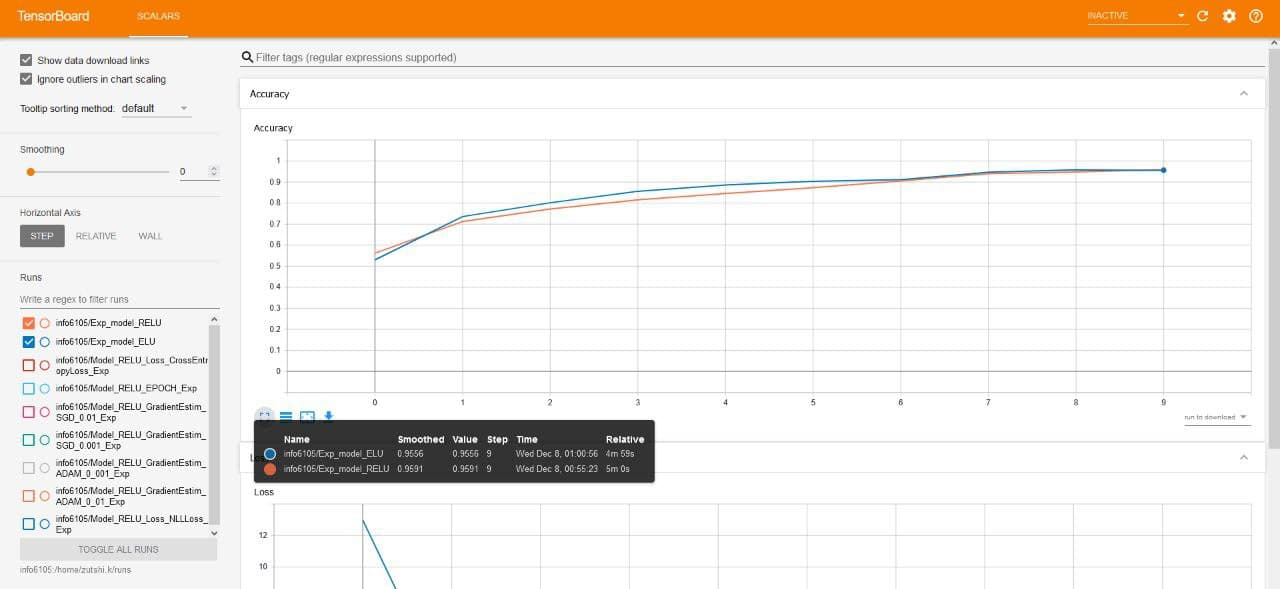
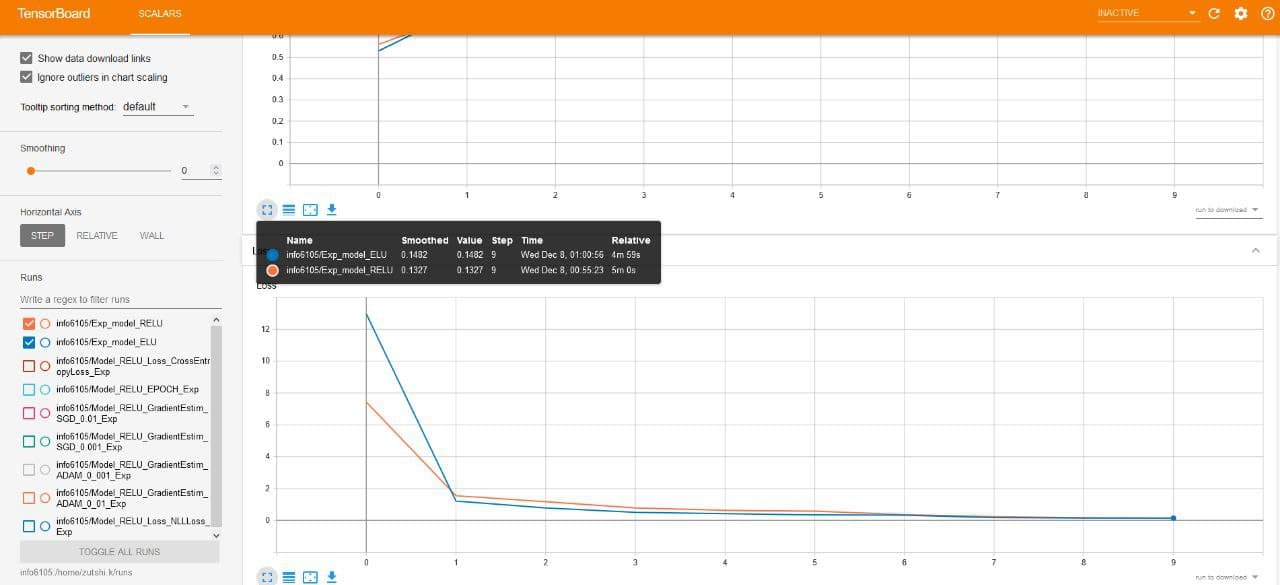


### 3.3 Affect of Different Cost Functions 2️⃣

Here I will try with 2 cost functions and observe the affects of these on accuracy, loss in Tensorboard - 

- Cross-Entropy ✅
- Negative Log likelihood(NLL) loss ✅

In [8]:
#CNN network for NLL loss
class ConvNet(nn.Module):
      def __init__(self, num_classes=6):
            
            super(ConvNet,self).__init__()

            # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
            # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,150,150)
            self.bn1 = nn.BatchNorm2d(num_features=12)
            #Shape -> (256,12,150,150)
            self.relu1 = nn.ReLU()
            #Shape -> (256,12,150,150)
            self.pool = nn.MaxPool2d(kernel_size=2)
            # Reduce the image size by factor of 2
            #Shape -> (256,12, 75,75)


            # 2nd Layer


            self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,75,75)
            self.relu2 = nn.ReLU()
            #Shape -> (256,20,75,75)


            # 3rd Layer


            self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,32,75,75)
            self.bn2 = nn.BatchNorm2d(num_features=32)
            #Shape -> (256,32,75,75)
            self.relu3 = nn.ReLU()
            #Shape -> (256,32,75,75) 

            self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)
            self.logSoftmax = nn.LogSoftmax(dim=1)

      # Feed forward function
      def forward(self, input):
            
            output = self.conv1(input)
            output = self.bn1(output)
            output = self.relu1(output)

            output = self.pool(output)

            output = self.conv2(output)
            output = self.relu2(output)

            output = self.conv3(output)
            output = self.bn2(output)
            output = self.relu3(output)

            # the output will be in matric form of shape (256,32,75,75)
            # in order to feed it to fully connected layer output needs to be reshaped

            output = output.view(-1,32*75*75)
            output = self.fullyConnected(output)
            output = self.logSoftmax(output)

            return output

In [9]:
model = ConvNet(num_classes=6).to(device)

In [10]:
summary(model, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
              ReLU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
            Conv2d-5           [-1, 20, 75, 75]           2,180
              ReLU-6           [-1, 20, 75, 75]               0
            Conv2d-7           [-1, 32, 75, 75]           5,792
       BatchNorm2d-8           [-1, 32, 75, 75]              64
              ReLU-9           [-1, 32, 75, 75]               0
           Linear-10                    [-1, 6]       1,080,006
       LogSoftmax-11                    [-1, 6]               0
Total params: 1,088,402
Trainable params: 1,088,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forw

In [52]:
# Training Loop

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
Adam_RELU = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam_RELU
criterion = NLLLoss

comment = f' ConvNet_RELU Adam_0_001 loss = NLLLoss'

tb = SummaryWriter(log_dir = 'runs/Model_RELU_Loss_NLLLoss_Exp',comment=comment)
for epoch in range(10):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=criterion(outputs,torch.unique(labels))
        
         #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = train_loss/train_count
    tb.add_scalar("Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
         #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

     # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
    print("epoch:", epoch, "Accuracy:", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")



tb.close()

In [ ]:
# ConvNet for CrossEntropy loss
class ConvNet(nn.Module):
      def __init__(self, num_classes=6):
            
            super(ConvNet,self).__init__()

            # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
            # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,150,150)
            self.bn1 = nn.BatchNorm2d(num_features=12)
            #Shape -> (256,12,150,150)
            self.relu1 = nn.ReLU()
            #Shape -> (256,12,150,150)
            self.pool = nn.MaxPool2d(kernel_size=2)
            # Reduce the image size by factor of 2
            #Shape -> (256,12, 75,75)


            # 2nd Layer


            self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,75,75)
            self.relu2 = nn.ReLU()
            #Shape -> (256,20,75,75)


            # 3rd Layer


            self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,32,75,75)
            self.bn2 = nn.BatchNorm2d(num_features=32)
            #Shape -> (256,32,75,75)
            self.relu3 = nn.ReLU()
            #Shape -> (256,32,75,75) 

            self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)

      # Feed forward function
      def forward(self, input):
            
            output = self.conv1(input)
            output = self.bn1(output)
            output = self.relu1(output)

            output = self.pool(output)

            output = self.conv2(output)
            output = self.relu2(output)

            output = self.conv3(output)
            output = self.bn2(output)
            output = self.relu3(output)

            # the output will be in matric form of shape (256,32,75,75)
            # in order to feed it to fully connected layer output needs to be reshaped

            output = output.view(-1,32*75*75)
            output = self.fullyConnected(output)

            return output


In [ ]:
model = ConvNet(num_classes=6).to(device)

In [ ]:
# Training Loop

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
Adam_RELU = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam_RELU
criterion = CrossEntropyLoss

comment = f' ConvNet_RELU Adam_0_001 loss = CrossEntropyLoss'

tb = SummaryWriter(log_dir = 'runs/Model_RELU_Loss_CrossEntropyLoss_Exp',comment=comment)
for epoch in range(10):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=criterion(outputs,torch.unique(labels))
        
         #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = train_loss/train_count
    tb.add_scalar("Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
         #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

     # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
    print("epoch:", epoch, "Accuracy:", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")



tb.close()

#### Accuracy and Loss Plots as from Tensorboard

NOTE : **For running the tensorboard in discovery cluster, we need to launch separate instance of tensorboard from Interactive Apps**

#### Inference 🔎

It is observed that the changes in Cost function didnt affect the output accuracy and loss by much, given the no. of epochs is 10. One reason being that cross entropy and NLL have similar calculation algorithm.
If this model is tested on a test set or validation set, we can know more about its performance.

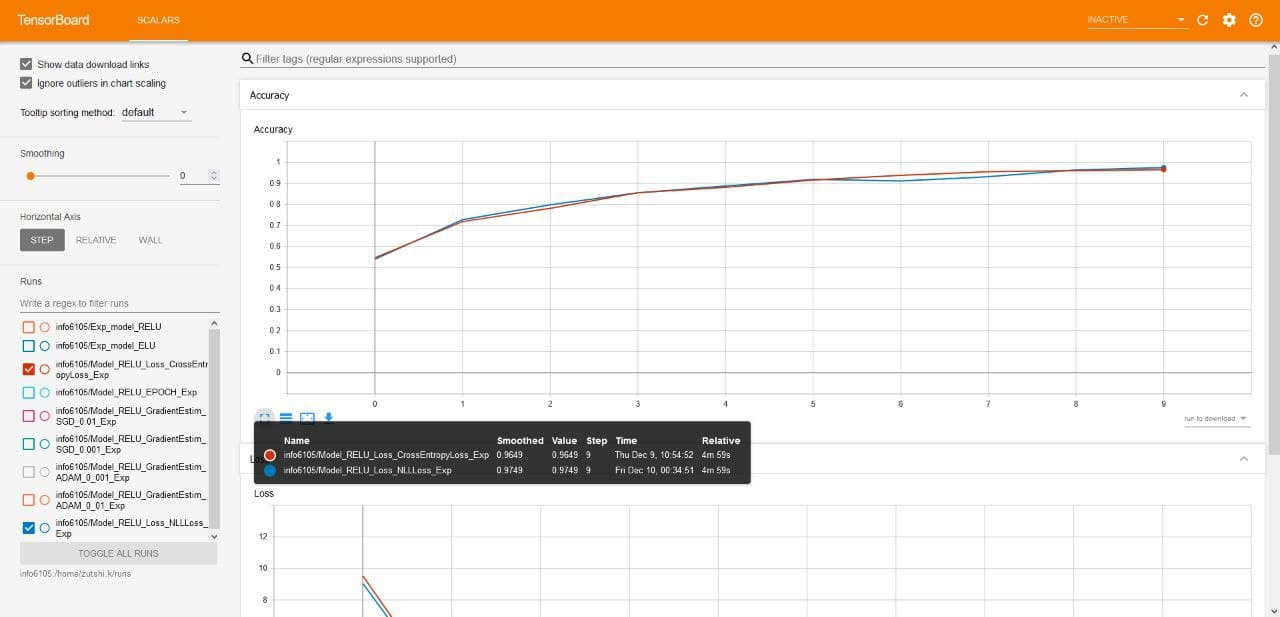
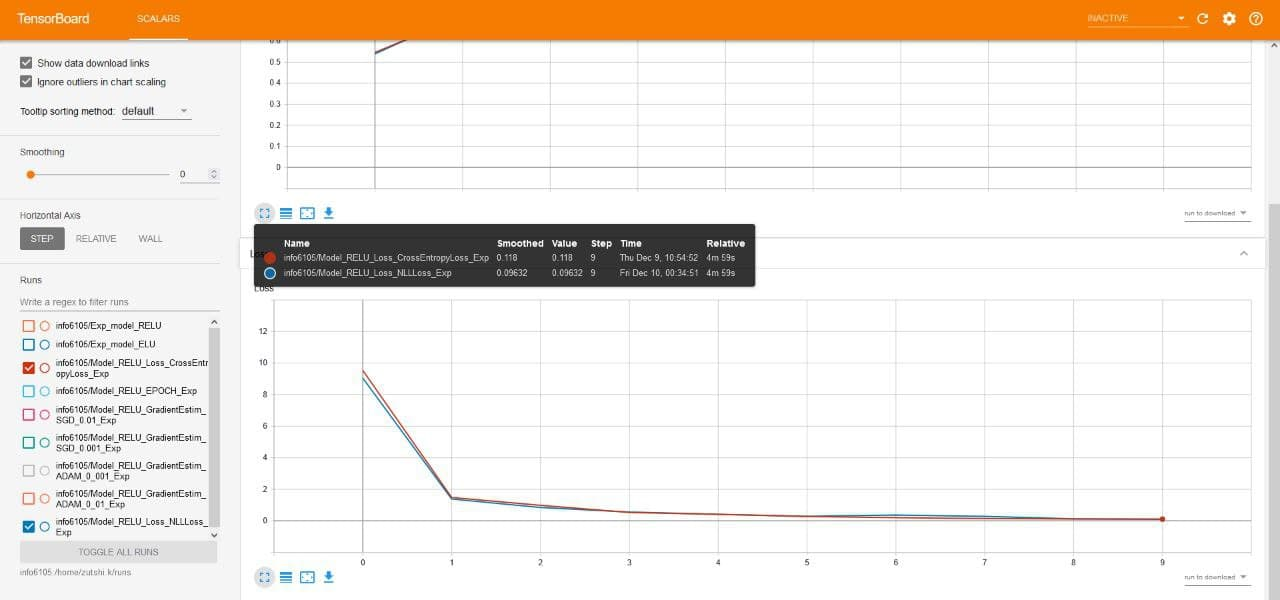


### 3.4 Affect of Different Epochs 3️⃣

Here I will record the training over **15 Epochs**, 5 more than usual Epochs run in previous experiments and observe the **affects** of these **on accuracy, loss** in Tensorboard - 


In [107]:
# Training Loop

# model = ConvNet().to(device)
train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
Adam_RELU = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam_RELU
loss = CrossEntropyLoss
comment = f' ConvNet_RELU Adam_0_001_CrossEntropy'
# print('LOSS HERE---',loss[run_id])
tb = SummaryWriter(log_dir = 'runs/Model_RELU_EPOCH_Exp',comment=comment)
for epoch in range(15):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=loss(outputs,labels)
        #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = train_loss/train_count
    tb.add_scalar("Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
     #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

    # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
    print("epoch:", epoch,"Accuracy", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")


tb.close()

epoch: 0 Accuracy 0.5484537551660253 loss: tensor(7.9433)
epoch: 1 Accuracy 0.7314379364400742 loss: tensor(1.1803)
epoch: 2 Accuracy 0.7855208778680348 loss: tensor(0.8853)
epoch: 3 Accuracy 0.827704147071398 loss: tensor(0.7189)
epoch: 4 Accuracy 0.8503634031637451 loss: tensor(0.6395)
epoch: 5 Accuracy 0.8740914920906371 loss: tensor(0.5730)
epoch: 6 Accuracy 0.9225452472566624 loss: tensor(0.2965)
epoch: 7 Accuracy 0.9430668376799202 loss: tensor(0.1907)
epoch: 8 Accuracy 0.9293145218754454 loss: tensor(0.2818)
epoch: 9 Accuracy 0.9288869887416275 loss: tensor(0.2906)
epoch: 10 Accuracy 0.9590993301980903 loss: tensor(0.1419)
epoch: 11 Accuracy 0.9619495510902095 loss: tensor(0.1366)
epoch: 12 Accuracy 0.9687188257089925 loss: tensor(0.1142)
epoch: 13 Accuracy 0.973421690180989 loss: tensor(0.0962)
epoch: 14 Accuracy 0.9883140943423115 loss: tensor(0.0461)
___________________________________________________________________


#### Accuracy and Loss Plots as from Tensorboard

NOTE : **For running the tensorboard in discovery cluster, we need to launch separate instance of tensorboard from Interactive Apps**

#### Inference 🔎

It is observed that the changes in Epoch runs affect the output accuracy and loss since the model reduces the subsequent loss by adjusting weights. We can see that perhaps the model may plateau after 15 epochs.
If this model is tested on a test set or validation set, we can know more about its performance.

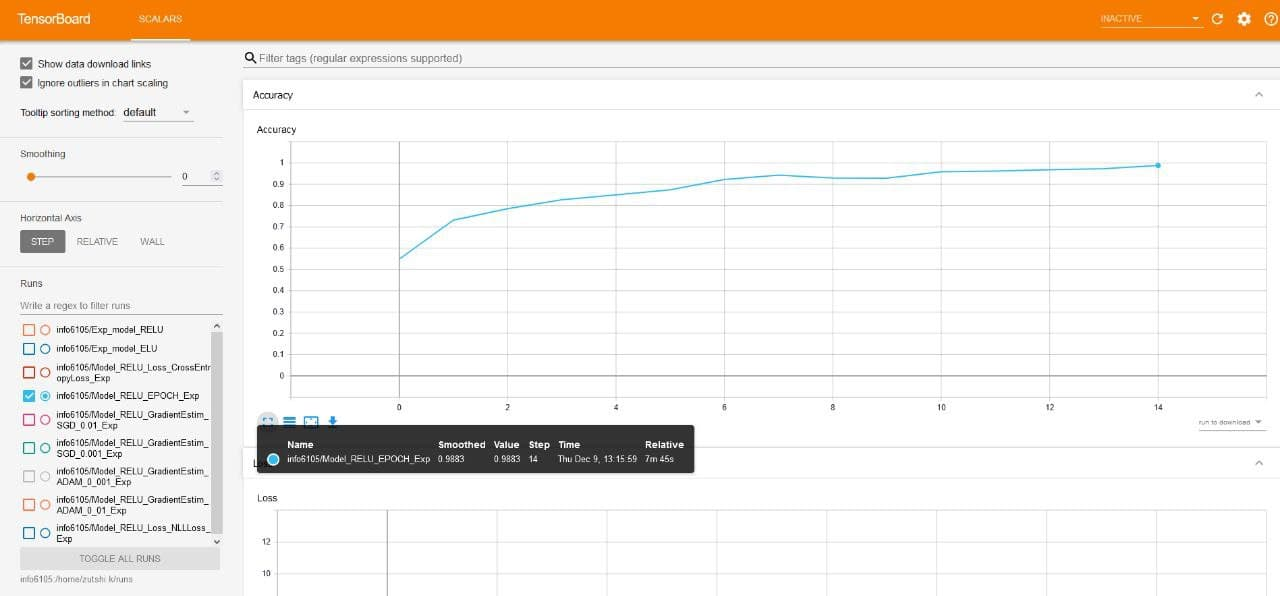
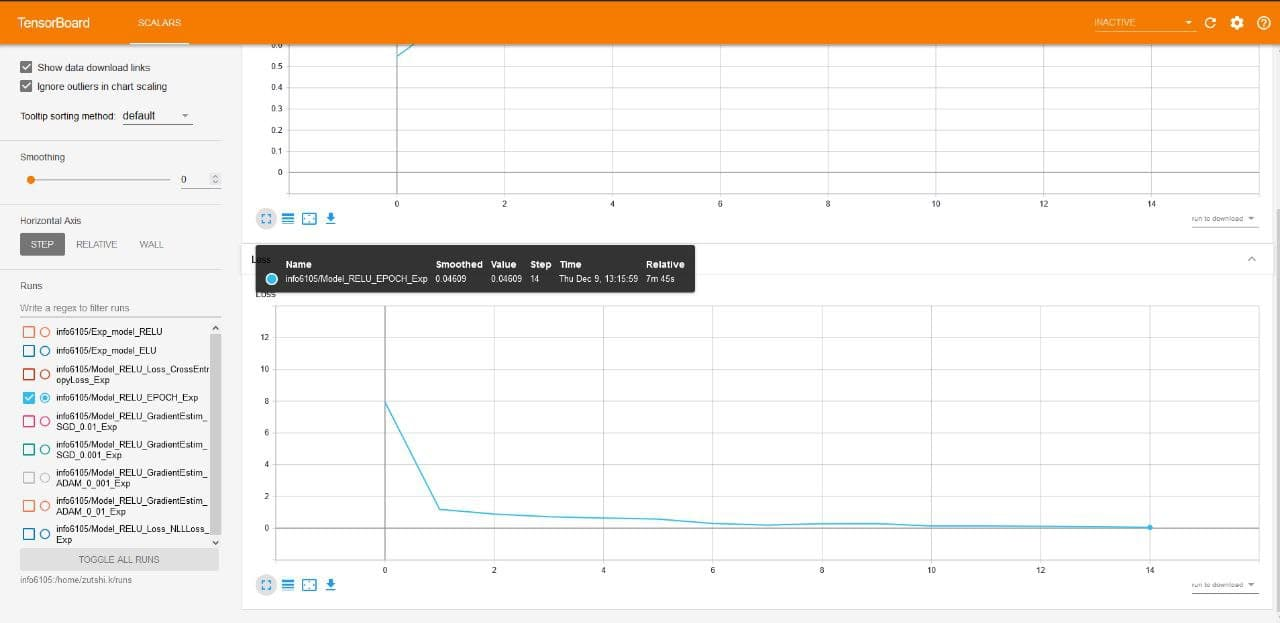

### 3.5 Affect of Different Gradient Estimation 4️⃣

Here I will compare two gradient estimations on ConvNet - 

Change the gradient estimation. How does it affect accuracy? How does it affect how quickly the network plateaus?
Various forms of gradient estimation:

- Adam ✅
- Stochastic Gradient Descent(SGD) ✅
- AGAdadelta
- Momentum
- Adagrad
- RMSProp

In [49]:
#  Training Loop on convnet RELU SGD with different Lr
# Learning Rate = 0.001
train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
optimizer = SGD(model.parameters(), lr=0.001)
loss_criterion = CrossEntropyLoss
# model_names= ['ConvNet_RELU', 'ConvNet_ELU']
comment = f'model_RELU batch_size=256 lr = 0.001 grad_est = SGD CrossEntropyLoss'
tb = SummaryWriter(log_dir = 'runs/Model_RELU_GradientEstim_SGD_0.001_Exp',comment=comment)
for epoch in range(12):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=loss_criterion(outputs,labels)
        #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))
#             preds = model_type(images)

#             lossObserved = loss_criterion(preds, labels)
#             total_loss+= lossObserved.item()
#             total_correct+= get_num_correct(preds, labels)

#             optimizer.zero_grad()
#             lossObserved.backward()
#             optimizer.step()


    tb.add_scalar("Loss", train_loss/train_count, epoch)
#         tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

    print("lr:", "0.001", "loss:", train_loss/train_count)
    print("epoch:", epoch,"Accuracy", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")

# tb.add_hparams(
#         {"model:",model_type, "batch_size:", batch_size,"gradient_est:",gradient_est, "loss:", loss},
#         {
#             "accuracy": total_correct/train_count,
#             "loss": total_loss,
#         },
#     )

tb.close()


lr: 0.001 loss: tensor(2.6736)
epoch: 0 Accuracy 0.4343736639589568 loss: tensor(2.6736)
lr: 0.001 loss: tensor(1.4788)
epoch: 1 Accuracy 0.5658401026079521 loss: tensor(1.4788)
lr: 0.001 loss: tensor(1.2393)
epoch: 2 Accuracy 0.6136525580732507 loss: tensor(1.2393)
lr: 0.001 loss: tensor(0.9904)
epoch: 3 Accuracy 0.6710845090494514 loss: tensor(0.9904)
lr: 0.001 loss: tensor(0.8806)
epoch: 4 Accuracy 0.7035770272196096 loss: tensor(0.8806)
lr: 0.001 loss: tensor(0.7800)
epoch: 5 Accuracy 0.725167450477412 loss: tensor(0.7800)
lr: 0.001 loss: tensor(0.7159)
epoch: 6 Accuracy 0.7504631608949693 loss: tensor(0.7159)
lr: 0.001 loss: tensor(0.6421)
epoch: 7 Accuracy 0.7719110731081659 loss: tensor(0.6421)
lr: 0.001 loss: tensor(0.5737)
epoch: 8 Accuracy 0.794712840245119 loss: tensor(0.5737)
lr: 0.001 loss: tensor(0.5364)
epoch: 9 Accuracy 0.8167307966367393 loss: tensor(0.5364)
lr: 0.001 loss: tensor(0.5096)
epoch: 10 Accuracy 0.8249964372238848 loss: tensor(0.5096)
lr: 0.001 loss: tensor

In [64]:
# Training Loop on convnet RELU Adam with different Lr
# for run_id, lrate in enumerate([0.01, 0.001]):
#     print("run id:", run_id + 1)
# #     model_type = model_RELU
train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
optimizer = Adam(model.parameters(), lr=0.01)
loss_criterion = CrossEntropyLoss
# model_names= ['ConvNet_RELU', 'ConvNet_ELU']
comment = f'model_RELU batch_size=256 lr = 0.01 grad_est = ADAM CrossEntropyLoss'
tb = SummaryWriter(log_dir = 'runs/Model_RELU_GradientEstim_ADAM_0_01_Exp',comment=comment)
for epoch in range(12):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=loss_criterion(outputs,labels)
        #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))
#             preds = model_type(images)

#             lossObserved = loss_criterion(preds, labels)
#             total_loss+= lossObserved.item()
#             total_correct+= get_num_correct(preds, labels)

#             optimizer.zero_grad()
#             lossObserved.backward()
#             optimizer.step()


    tb.add_scalar("Loss", train_loss/train_count, epoch)
#         tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

    print("lr:", "0.01", "loss:", train_loss/train_count)
    print("epoch:", epoch,"Accuracy", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")

# tb.add_hparams(
#         {"model:",model_type, "batch_size:", batch_size,"gradient_est:",gradient_est, "loss:", loss},
#         {
#             "accuracy": total_correct/train_count,
#             "loss": total_loss,
#         },
#     )

tb.close()


lr: 0.01 loss: tensor(102.5951)
epoch: 0 Accuracy 0.36447199657973495 loss: tensor(102.5951)
lr: 0.01 loss: tensor(3.1781)
epoch: 1 Accuracy 0.2089924469146359 loss: tensor(3.1781)
lr: 0.01 loss: tensor(1.8011)
epoch: 2 Accuracy 0.2003705287159755 loss: tensor(1.8011)
lr: 0.01 loss: tensor(1.7554)
epoch: 3 Accuracy 0.2341456462875873 loss: tensor(1.7554)
lr: 0.01 loss: tensor(1.6868)
epoch: 4 Accuracy 0.28395325637736923 loss: tensor(1.6868)
lr: 0.01 loss: tensor(1.5210)
epoch: 5 Accuracy 0.4112156192104888 loss: tensor(1.5210)
lr: 0.01 loss: tensor(1.3514)
epoch: 6 Accuracy 0.48304118569189114 loss: tensor(1.3514)
lr: 0.01 loss: tensor(1.2058)
epoch: 7 Accuracy 0.533205073393188 loss: tensor(1.2058)
lr: 0.01 loss: tensor(1.1178)
epoch: 8 Accuracy 0.5669089354424968 loss: tensor(1.1178)
lr: 0.01 loss: tensor(1.2785)
epoch: 9 Accuracy 0.48959669374376513 loss: tensor(1.2785)
lr: 0.01 loss: tensor(1.1189)
epoch: 10 Accuracy 0.5684053014108593 loss: tensor(1.1189)
lr: 0.01 loss: tensor(1.

#### Accuracy and Loss Plots as from Tensorboard

NOTE : **For running the tensorboard in discovery cluster, we need to launch separate instance of tensorboard from Interactive Apps**

#### Inference 🔎

It is observed that the changes in Gradient Estimatations affect the output accuracy and loss by a significant factor, given the no. of epochs is 12. The model using RELU activation ADAM gradient with 0.01 learning rate performs best.
If this model is tested on a test set or validation set, we can know more about its performance.

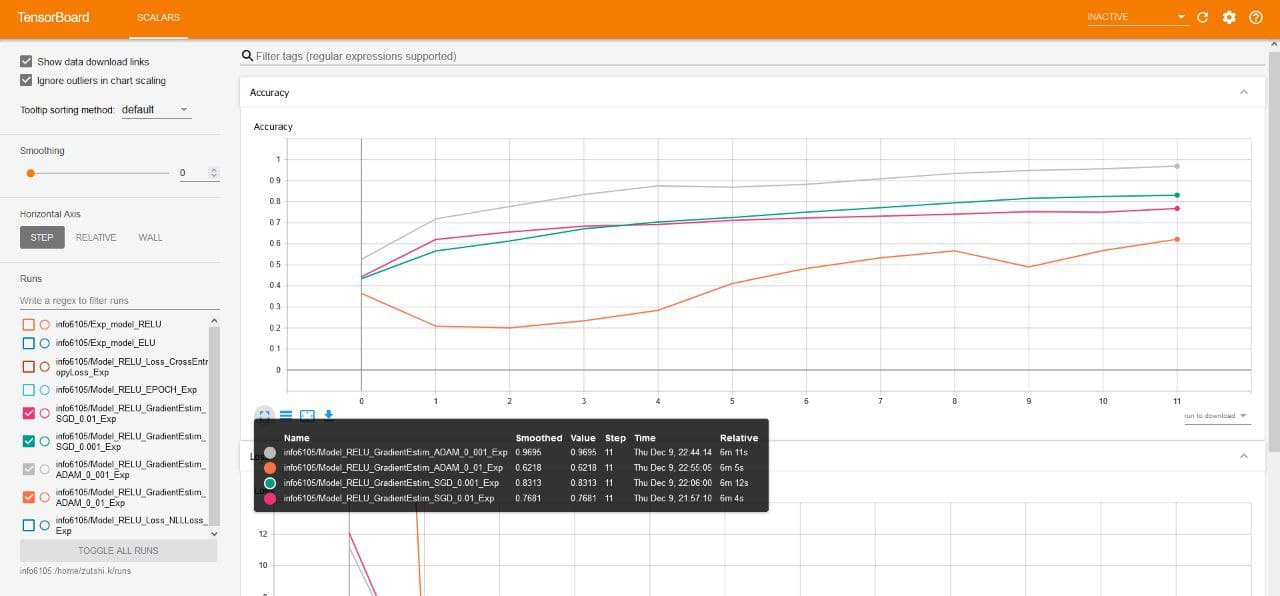
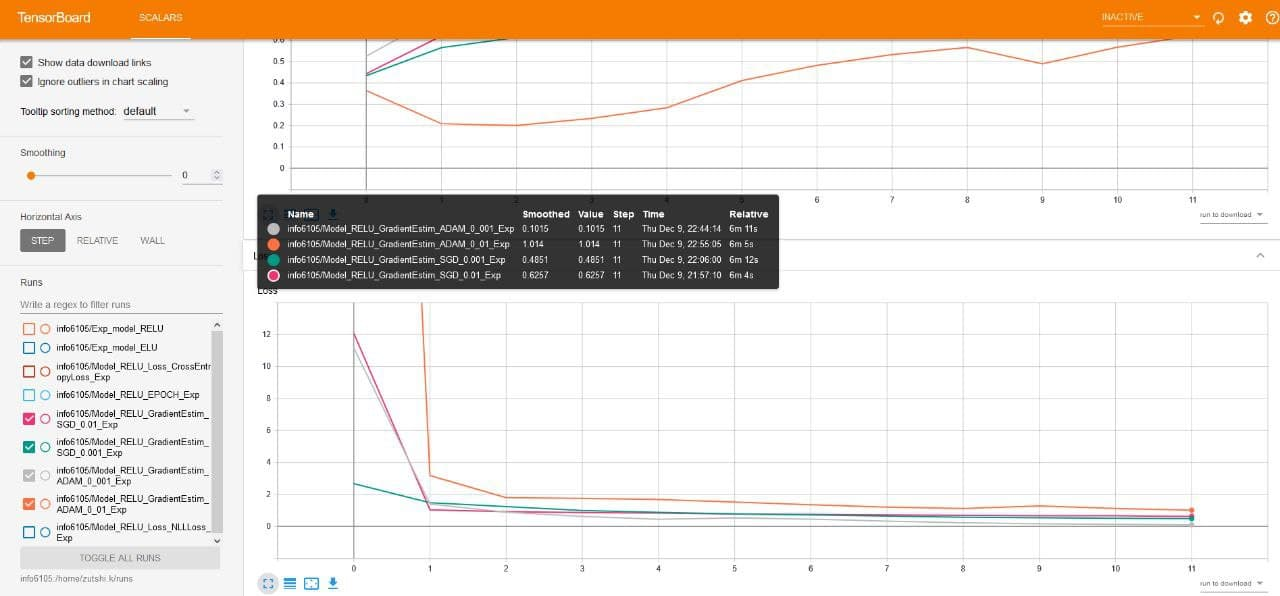

### 3.6 Affect of Different Network Architectures 5️⃣

On the Deep Learning model changing the network architecture. How does it affect accuracy? How does it affect how quickly the network plateaus?

Various forms of network architecture:

- Number of layers

- Size of each layer

- Connection type


In [11]:
#CNN network extra layer
class ConvNet_RELU(nn.Module):
  def __init__(self, num_classes=6):
    super(ConvNet_RELU,self).__init__()

    # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
    # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,12,150,150)
    self.bn1 = nn.BatchNorm2d(num_features=12)
    #Shape -> (256,12,150,150)
    self.relu1 = nn.ReLU()
    #Shape -> (256,12,150,150)
    self.pool = nn.MaxPool2d(kernel_size=2)
    # Reduce the image size by factor of 2
    #Shape -> (256,12, 75,75)


    # 2nd Layer

    
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,12,75,75)
    self.relu2 = nn.ReLU()
    #Shape -> (256,20,75,75)

    
    # 3rd Layer

    
    self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,32,75,75)
    self.bn2 = nn.BatchNorm2d(num_features=32)
    #Shape -> (256,32,75,75)
    self.relu3 = nn.ReLU()
    #Shape -> (256,32,75,75) 
    
    # 4th layer Added Extra Layer to check the affect on Accuracy&Loss ✔
    
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=44, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,32,75,75)
    self.bn3 = nn.BatchNorm2d(num_features=44)
    #Shape -> (256,32,75,75)
    self.relu4 = nn.ReLU()
    #Shape -> (256,32,75,75) 

    self.fullyConnected = nn.Linear(in_features=44*75*75, out_features=num_classes)

# Feed forward function
  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.relu2(output)

    output = self.conv3(output)
    output = self.bn2(output)
    output = self.relu3(output)
    
    output = self.conv4(output)
    output = self.bn3(output)
    output = self.relu4(output)

    # the output will be in matric form of shape (256,32,75,75)
    # in order to feed it to fully connected layer output needs to be reshaped

    output = output.view(-1,44*75*75)
    output = self.fullyConnected(output)

    return output


In [12]:
model_RELU = ConvNet_RELU(num_classes=6).to(device)

In [13]:
summary(model_RELU, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
              ReLU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
            Conv2d-5           [-1, 20, 75, 75]           2,180
              ReLU-6           [-1, 20, 75, 75]               0
            Conv2d-7           [-1, 32, 75, 75]           5,792
       BatchNorm2d-8           [-1, 32, 75, 75]              64
              ReLU-9           [-1, 32, 75, 75]               0
           Conv2d-10           [-1, 44, 75, 75]          12,716
      BatchNorm2d-11           [-1, 44, 75, 75]              88
             ReLU-12           [-1, 44, 75, 75]               0
           Linear-13                    [-1, 6]       1,485,006
Total params: 1,506,206
Trainable param

In [58]:
# Training

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
Adam_RELU = Adam(model_RELU.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam_RELU
criterion = CrossEntropyLoss

comment = f' ConvNet_RELU Adam_0_001 loss = CrossEntropyLoss'

tb = SummaryWriter(log_dir = 'runs/Model_RELU_Netw_Arch_Exp',comment=comment)
for epoch in range(12):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model_RELU(images)
        # cal loss using pred and actual value
        lossEpoch=criterion(outputs,labels)
        
         #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = train_loss/train_count
    tb.add_scalar("Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
         #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

     # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
    print("epoch:", epoch, "Accuracy:", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")



tb.close()

epoch: 0 Accuracy: 0.5078381074533276 loss: tensor(13.9754)
epoch: 1 Accuracy: 0.6901809890266496 loss: tensor(1.7204)
epoch: 2 Accuracy: 0.7696308963944706 loss: tensor(0.9795)
epoch: 3 Accuracy: 0.8134530426108023 loss: tensor(0.7053)
epoch: 4 Accuracy: 0.8349009548239988 loss: tensor(0.6299)
epoch: 5 Accuracy: 0.8448767279464159 loss: tensor(0.6283)
epoch: 6 Accuracy: 0.8886276186404446 loss: tensor(0.4116)
epoch: 7 Accuracy: 0.927319367250962 loss: tensor(0.2586)
epoch: 8 Accuracy: 0.9113581302550948 loss: tensor(0.3433)
epoch: 9 Accuracy: 0.9234715690466011 loss: tensor(0.3014)
epoch: 10 Accuracy: 0.956747897962092 loss: tensor(0.1614)
epoch: 11 Accuracy: 0.9429955821576173 loss: tensor(0.2208)
___________________________________________________________________


In [14]:
#CNN network no extra layer, additional layer removed
class ConvNet_RELU(nn.Module):
  def __init__(self, num_classes=6):
    super(ConvNet_RELU,self).__init__()

    # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
    # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,12,150,150)
    self.bn1 = nn.BatchNorm2d(num_features=12)
    #Shape -> (256,12,150,150)
    self.relu1 = nn.ReLU()
    #Shape -> (256,12,150,150)
    self.pool = nn.MaxPool2d(kernel_size=2)
    # Reduce the image size by factor of 2
    #Shape -> (256,12, 75,75)


    # 2nd Layer

    
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,12,75,75)
    self.bn2 = nn.BatchNorm2d(num_features=20)
    self.relu2 = nn.ReLU()
    #Shape -> (256,20,75,75)

    
    # 3rd Layer

    
#     self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
#     #Shape -> (256,32,75,75)
#     self.bn2 = nn.BatchNorm2d(num_features=32)
#     #Shape -> (256,32,75,75)
#     self.relu3 = nn.ReLU()
    #Shape -> (256,32,75,75) 
    
    # 4th layer Added Extra Layer to check the affect on Accuracy&Loss ✔
    
#     self.conv4 = nn.Conv2d(in_channels=32, out_channels=44, kernel_size=3, stride=1, padding=1)
    #Shape -> (256,32,75,75)
#     self.bn3 = nn.BatchNorm2d(num_features=44)
    #Shape -> (256,32,75,75)
#     self.relu4 = nn.ReLU()
    #Shape -> (256,32,75,75) 

    self.fullyConnected = nn.Linear(in_features=20*75*75, out_features=num_classes)

# Feed forward function
  def forward(self, input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.bn2(output)
    output = self.relu2(output)

#     output = self.conv3(output)
    
#     output = self.relu3(output)
    
#     output = self.conv4(output)
#     output = self.bn3(output)
#     output = self.relu4(output)

    # the output will be in matric form of shape (256,32,75,75)
    # in order to feed it to fully connected layer output needs to be reshaped

    output = output.view(-1,20*75*75)
    output = self.fullyConnected(output)

    return output

In [15]:
model_RELU = ConvNet_RELU(num_classes=6).to(device)

In [16]:
summary(model_RELU, (3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 150, 150]             336
       BatchNorm2d-2         [-1, 12, 150, 150]              24
              ReLU-3         [-1, 12, 150, 150]               0
         MaxPool2d-4           [-1, 12, 75, 75]               0
            Conv2d-5           [-1, 20, 75, 75]           2,180
       BatchNorm2d-6           [-1, 20, 75, 75]              40
              ReLU-7           [-1, 20, 75, 75]               0
            Linear-8                    [-1, 6]         675,006
Total params: 677,586
Trainable params: 677,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 9.27
Params size (MB): 2.58
Estimated Total Size (MB): 12.11
----------------------------------------------------------------


In [61]:
# Training

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
Adam_RELU = Adam(model_RELU.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam_RELU
criterion = CrossEntropyLoss

comment = f' ConvNet_RELU Adam_0_001_2_layer loss = CrossEntropyLoss'

tb = SummaryWriter(log_dir = 'runs/Model_RELU_Netw_Arch_2_layer_Exp',comment=comment)
for epoch in range(12):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model_RELU(images)
        # cal loss using pred and actual value
        lossEpoch=criterion(outputs,labels)
        
         #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = train_loss/train_count
    tb.add_scalar("Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
         #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

     # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
    print("epoch:", epoch, "Accuracy:", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")



tb.close()

epoch: 0 Accuracy: 0.5389055151774262 loss: tensor(7.6321)
epoch: 1 Accuracy: 0.725238705999715 loss: tensor(1.0242)
epoch: 2 Accuracy: 0.8063274903805044 loss: tensor(0.6265)
epoch: 3 Accuracy: 0.844449194812598 loss: tensor(0.4784)
epoch: 4 Accuracy: 0.8666096622488243 loss: tensor(0.4380)
epoch: 5 Accuracy: 0.8916203505771697 loss: tensor(0.3297)
epoch: 6 Accuracy: 0.9386489952971355 loss: tensor(0.1906)
epoch: 7 Accuracy: 0.9526863331908223 loss: tensor(0.1559)
epoch: 8 Accuracy: 0.9616645290009975 loss: tensor(0.1277)
epoch: 9 Accuracy: 0.9731366680917771 loss: tensor(0.0948)
epoch: 10 Accuracy: 0.956961664529001 loss: tensor(0.1420)
epoch: 11 Accuracy: 0.9759868889838963 loss: tensor(0.0826)
___________________________________________________________________


#### Accuracy and Loss Plots as from Tensorboard

NOTE : **For running the tensorboard in discovery cluster, we need to launch separate instance of tensorboard from Interactive Apps**

#### Inference 🔎

It is observed that the changes in network architecture by adding another hidden layer and also having just 2 layers in the network, given the no. of epochs is 12 -> the one with lesser number of layers performed slightly better, suggesting that adding layers beyond a point perhaps dosent affect performance.
If this model is tested on a test set or validation set, we can know more about its performance and whether the high accuracy and low loss in 2 layer model is actually good or not.

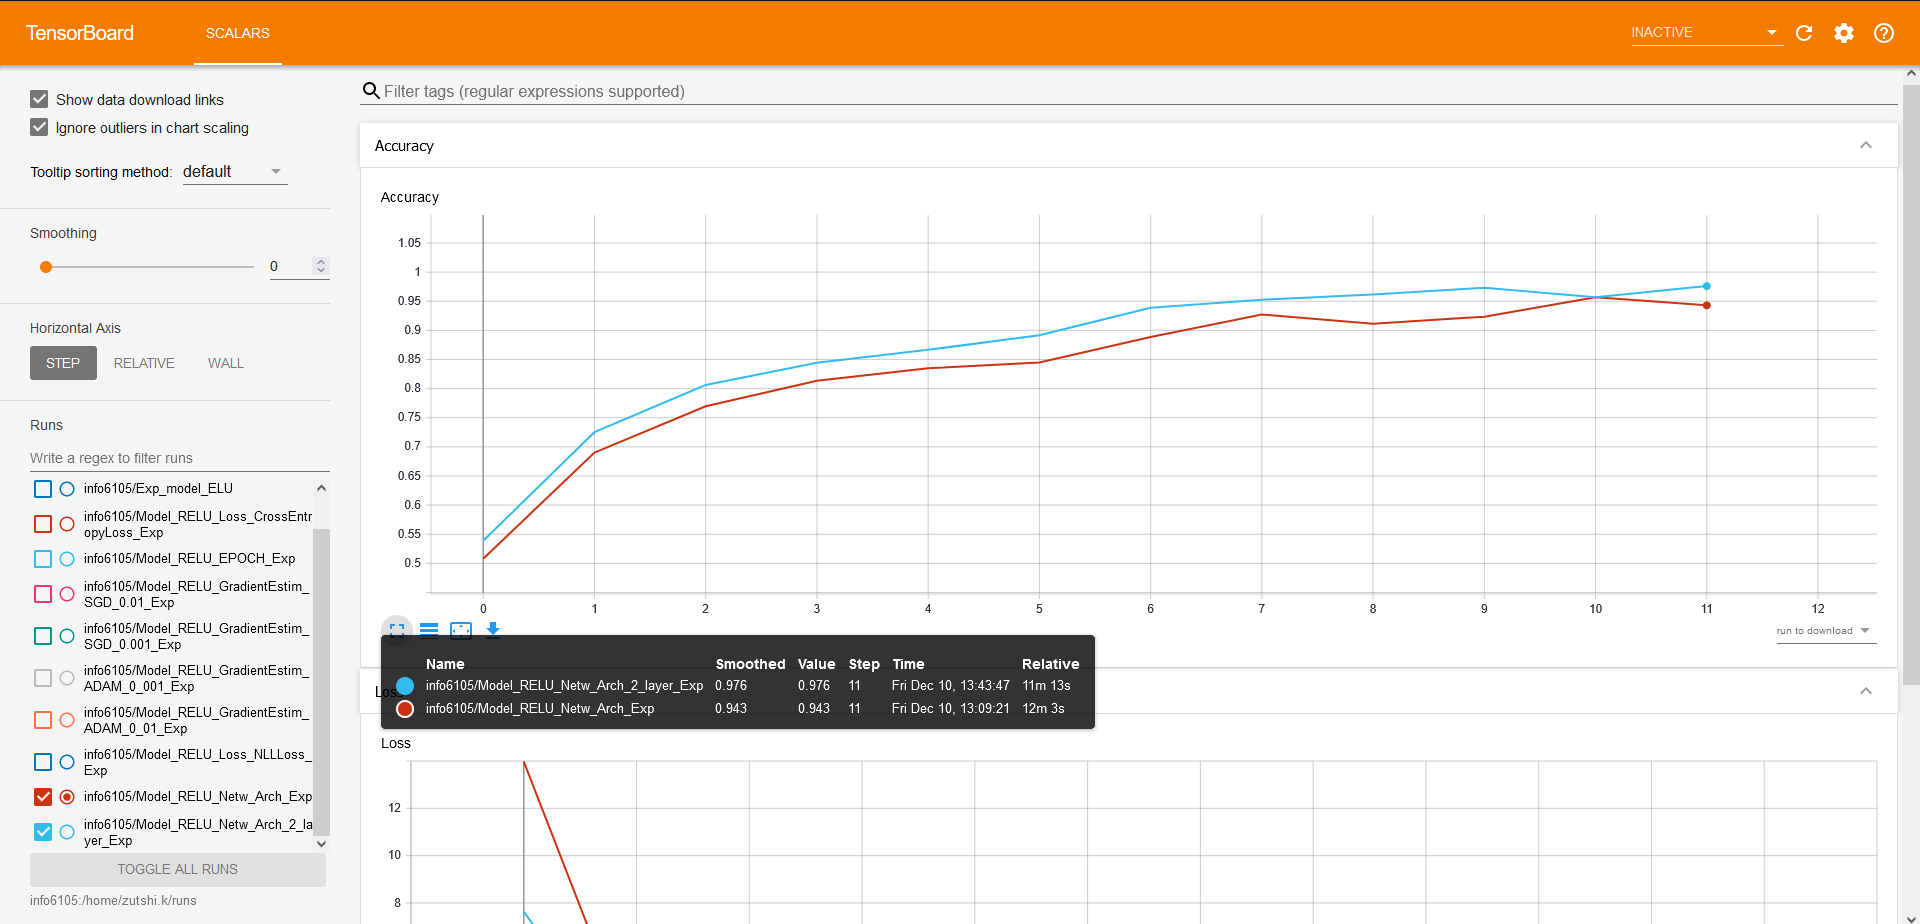
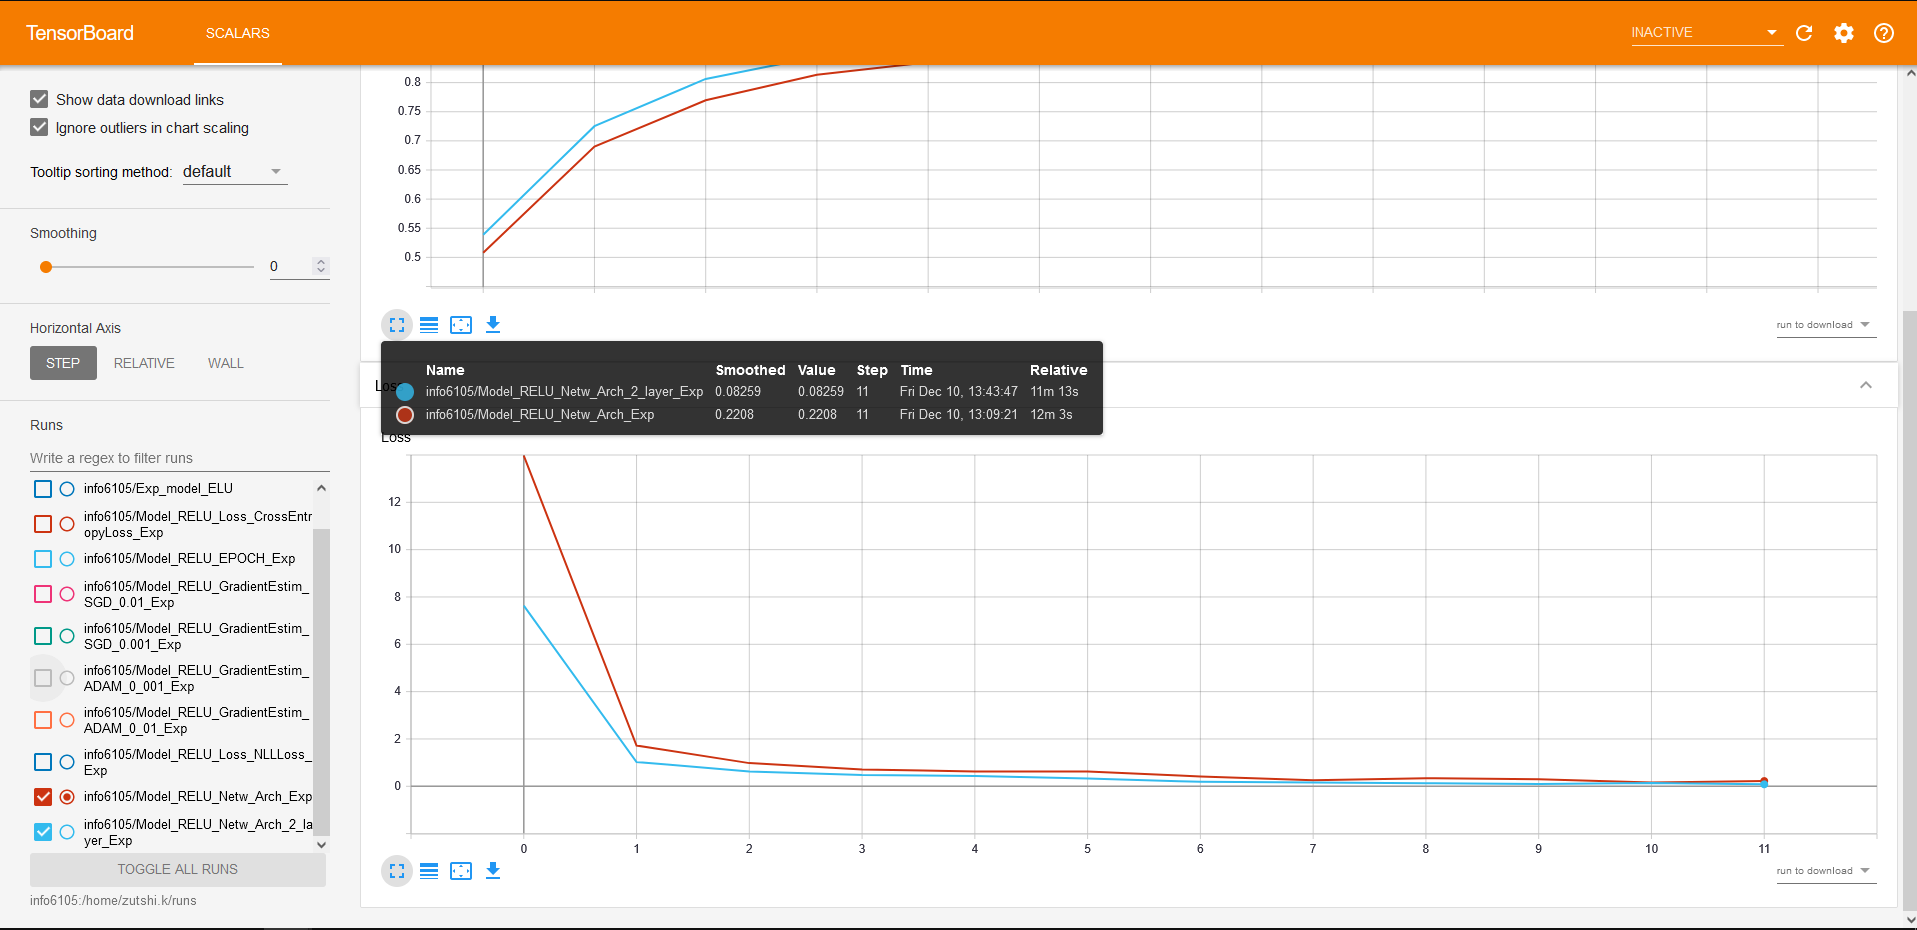

### 3.7 Affect of Different Network Initialization 6️⃣
Change the network initialization. How does it affect accuracy? How does it affect how quickly the network plateaus?

Various forms of network initialization:

- 0
- UniformGaussian
- Xavier Uniform ✅
- Glorot Initialization ->  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initializationXavier
- Uniform
- Xavier Gaussian
- Kaiming He Uniform ✅

Reference - https://www.youtube.com/watch?v=xWQ-p_o0Uik

In [69]:
#CNN network 
class ConvNet(nn.Module):
      def __init__(self, num_classes=6):
            
            super(ConvNet,self).__init__()

            # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
            # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,150,150)
            
#             nn.init.xavier_normal_(self.conv1.weight)
            
            self.bn1 = nn.BatchNorm2d(num_features=12)
            #Shape -> (256,12,150,150)
            self.relu1 = nn.ReLU()
            #Shape -> (256,12,150,150)
            self.pool = nn.MaxPool2d(kernel_size=2)
            # Reduce the image size by factor of 2
            #Shape -> (256,12, 75,75)


            # 2nd Layer


            self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,75,75)
            
#             nn.init.xavier_normal_(self.conv2.weight)
            
            self.relu2 = nn.ReLU()
            #Shape -> (256,20,75,75)


            # 3rd Layer


            self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,32,75,75)
            
#             nn.init.xavier_normal_(self.conv3.weight)
            
            self.bn2 = nn.BatchNorm2d(num_features=32)
            #Shape -> (256,32,75,75)
            self.relu3 = nn.ReLU()
            #Shape -> (256,32,75,75) 

            self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)
            
#             self.initialize_weights()

      
                    
      # Feed forward function
      def forward(self, input):
            
            output = self.conv1(input)
            output = self.bn1(output)
            output = self.relu1(output)

            output = self.pool(output)

            output = self.conv2(output)
            output = self.relu2(output)

            output = self.conv3(output)
            output = self.bn2(output)
            output = self.relu3(output)

            # the output will be in matric form of shape (256,32,75,75)
            # in order to feed it to fully connected layer output needs to be reshaped

            output = output.view(-1,32*75*75)
            output = self.fullyConnected(output)

            return output


In [66]:
# with Kaiming uniform weight init
def initialize_weights(m):
        if isinstance(m, nn.Conv2d):
                
            nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
                    
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight.data, 1)
            nn.init.constant_(m.bias.data, 0)
            
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)

In [67]:
model = ConvNet(num_classes=6).to(device)
model.apply(initialize_weights)

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fullyConnected): Linear(in_features=180000, out_features=6, bias=True)
)

In [68]:
# Training with Kaiming wt init

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
Adam_RELU = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam_RELU
criterion = CrossEntropyLoss

comment = f' ConvNet_RELU Adam_0_001_Wt_init_kaiming_uniform_ loss = CrossEntropyLoss'

tb = SummaryWriter(log_dir = 'runs/Model_RELU_Wt_init_kaiming_uniform__Exp',comment=comment)
for epoch in range(12):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=criterion(outputs,labels)
        
         #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = train_loss/train_count
    tb.add_scalar("Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
         #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

     # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
    print("epoch:", epoch, "Accuracy:", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")



tb.close()

epoch: 0 Accuracy: 0.5225880005700442 loss: tensor(11.5776)
epoch: 1 Accuracy: 0.7240273621205643 loss: tensor(1.4212)
epoch: 2 Accuracy: 0.7963517172580875 loss: tensor(0.8307)
epoch: 3 Accuracy: 0.834188399600969 loss: tensor(0.6760)
epoch: 4 Accuracy: 0.8694598831409435 loss: tensor(0.5562)
epoch: 5 Accuracy: 0.920478837109876 loss: tensor(0.2864)
epoch: 6 Accuracy: 0.9488385349864614 loss: tensor(0.1777)
epoch: 7 Accuracy: 0.9281031779962947 loss: tensor(0.2400)
epoch: 8 Accuracy: 0.9383639732079236 loss: tensor(0.2105)
epoch: 9 Accuracy: 0.926891834117144 loss: tensor(0.2979)
epoch: 10 Accuracy: 0.9432093487245261 loss: tensor(0.1978)
epoch: 11 Accuracy: 0.9677212483967508 loss: tensor(0.1071)
___________________________________________________________________


In [70]:
# with Xavier uniform weight init
def initialize_weights(m):
        if isinstance(m, nn.Conv2d):
                
            nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
                    
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight.data, 1)
            nn.init.constant_(m.bias.data, 0)
            
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)

In [71]:
model = ConvNet(num_classes=6).to(device)
model.apply(initialize_weights)

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fullyConnected): Linear(in_features=180000, out_features=6, bias=True)
)

In [72]:
# Training with Xavier wt init

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
Adam_RELU = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam_RELU
criterion = CrossEntropyLoss

comment = f' ConvNet_RELU Adam_0_001_Wt_init_xavier_uniform_ loss = CrossEntropyLoss'

tb = SummaryWriter(log_dir = 'runs/Model_RELU_Wt_init_xavier_uniform__Exp',comment=comment)
for epoch in range(12):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=criterion(outputs,labels)
        
         #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = train_loss/train_count
    tb.add_scalar("Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
         #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Accuracy", train_accuracy/train_count, epoch)

     # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
    print("epoch:", epoch, "Accuracy:", train_accuracy/train_count,"loss:",train_loss/train_count)
print("___________________________________________________________________")



tb.close()

epoch: 0 Accuracy: 0.5323500071255522 loss: tensor(8.2226)
epoch: 1 Accuracy: 0.7506056719395753 loss: tensor(1.1656)
epoch: 2 Accuracy: 0.788086076670942 loss: tensor(0.9962)
epoch: 3 Accuracy: 0.8656833404588855 loss: tensor(0.5359)
epoch: 4 Accuracy: 0.8932592275901382 loss: tensor(0.4032)
epoch: 5 Accuracy: 0.9226165027789653 loss: tensor(0.2834)
epoch: 6 Accuracy: 0.9422830269345874 loss: tensor(0.2018)
epoch: 7 Accuracy: 0.9588855636311814 loss: tensor(0.1436)
epoch: 8 Accuracy: 0.9484110018526436 loss: tensor(0.1930)
epoch: 9 Accuracy: 0.950334900954824 loss: tensor(0.1743)
epoch: 10 Accuracy: 0.9551090209491235 loss: tensor(0.1629)
epoch: 11 Accuracy: 0.9611657403448767 loss: tensor(0.1377)
___________________________________________________________________


#### Accuracy and Loss Plots as from Tensorboard

NOTE : **For running the tensorboard in discovery cluster, we need to launch separate instance of tensorboard from Interactive Apps**

#### Inference 🔎

It is observed that the changes in network weight initialization, given the no. of epochs is 12 -> both the techniques Xavier uniform and Kaiming He Uniform gave similar results in accuracy. Although the loss plot shows that xavier weights initialization brought the initial loss very much lower than Kaiming He.
If this model is tested on a test set or validation set, we can know more about its performance and whether the high accuracy and low loss in both of these models is actually good or not.

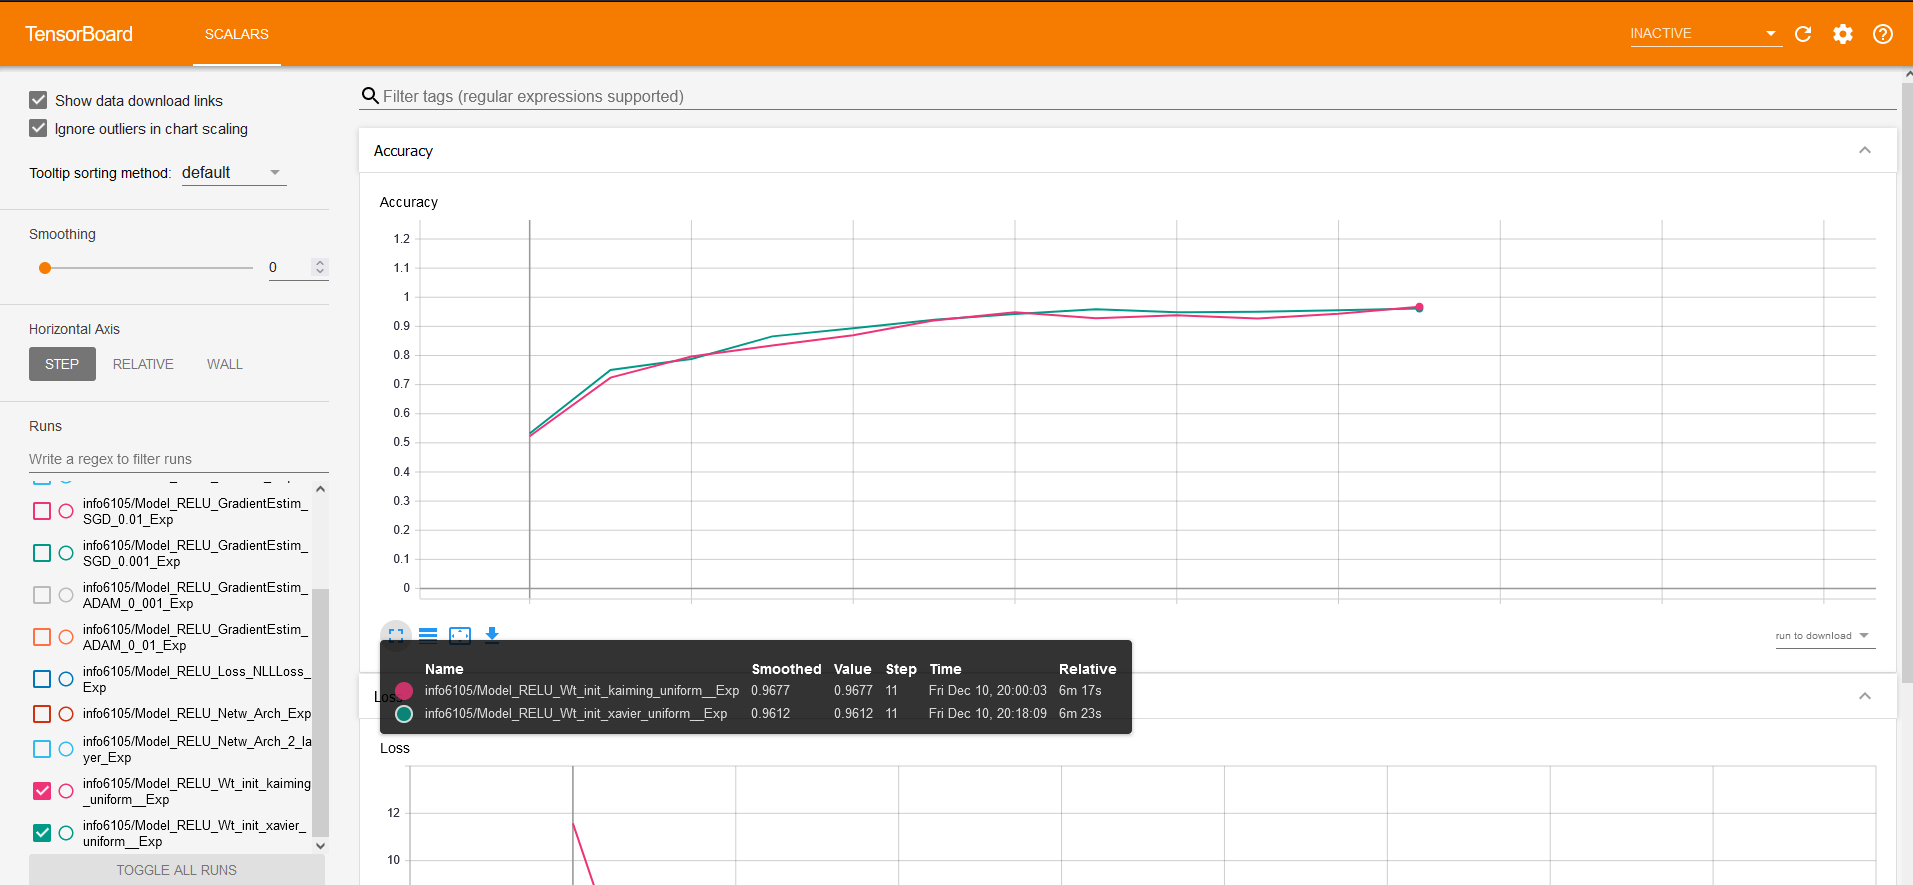
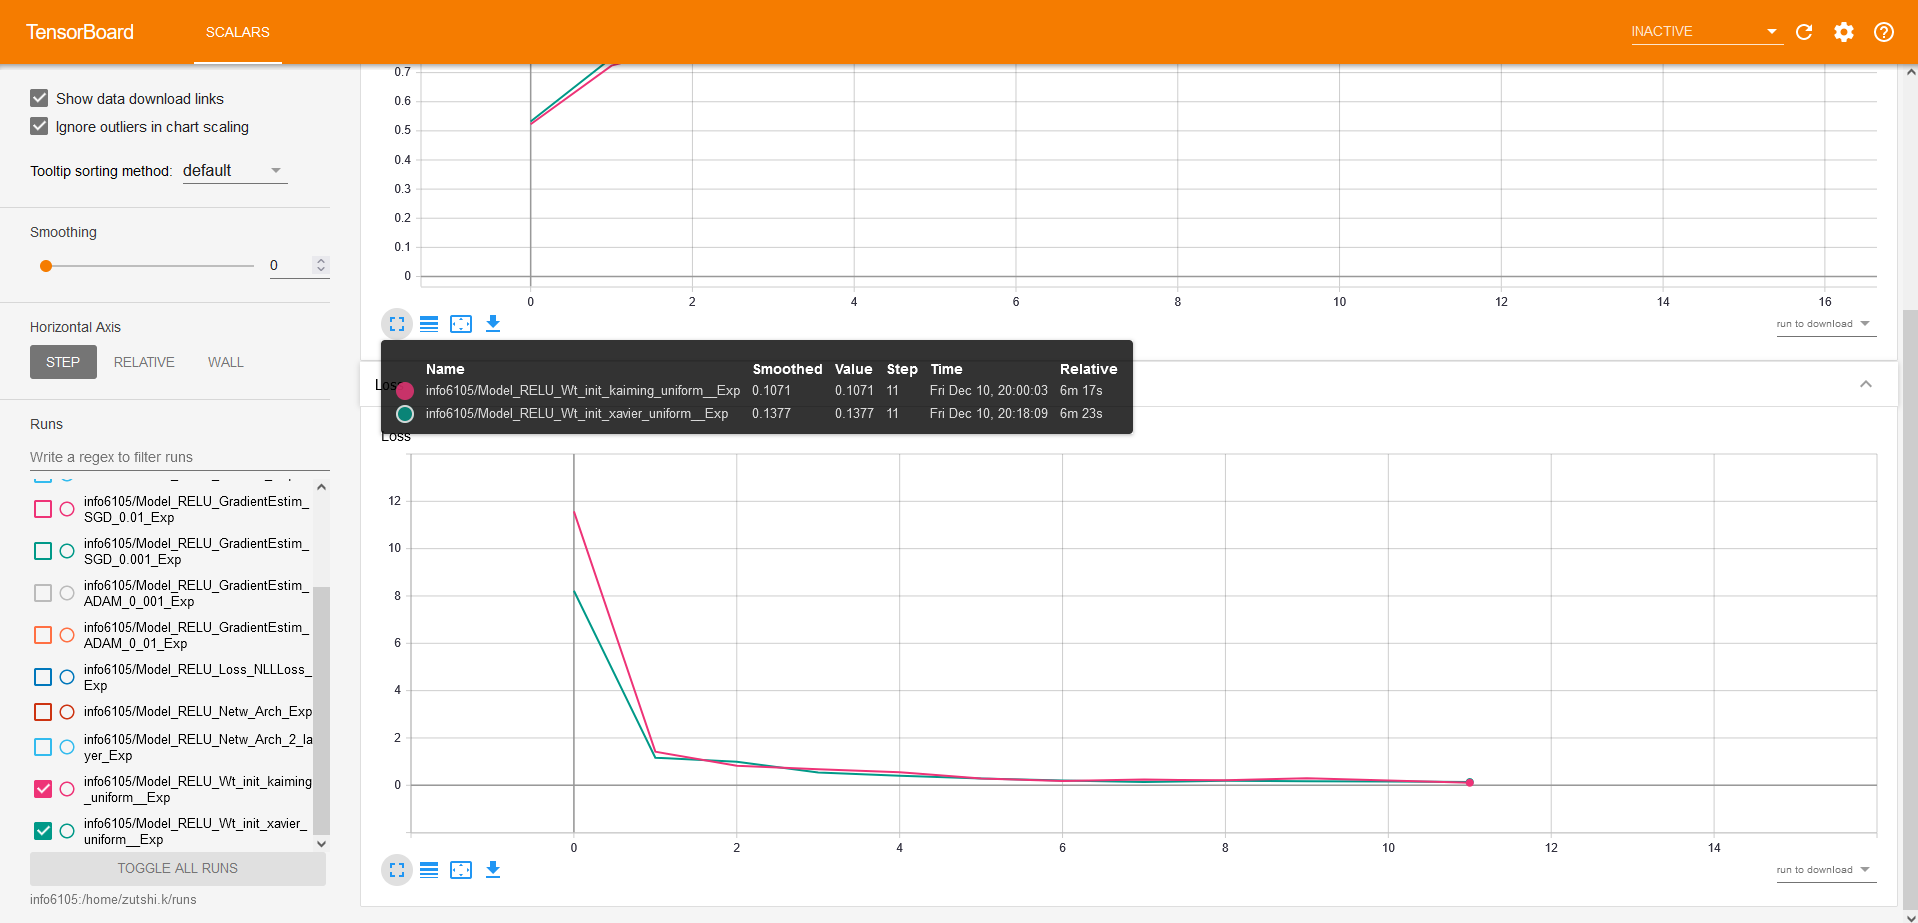

### 3.8 Training the CNN with the dataset & model saving 📩

Training the CNN with the dataset and saving the best model based on best test accuracy

Based on the above permutations of activation functions/loss/Epochs/gradient estimate/network arch and weight init., We can move ahead with using a good model choice among these and save the model for Validation data preditions(unlabelled data).

Model to use - **Model_RELU_Wt_init_kaiming_uniform_Exp**

- Activation Fn -> ReLU ✔
- Cost fn -> CrossEntropy Loss ✔
- Gradient Est. -> Adam with lr=0.01 ✔
- Network Arch -> 3 layer ReLU CNN ✔
- Weight Init -> Kaiming he Uniform ✔

In [26]:
#CNN network 
class ConvNet(nn.Module):
      def __init__(self, num_classes=6):
            
            super(ConvNet,self).__init__()

            # Input Shape = (256,3,150,150) -> (Batch size, no. of channels, 150, 150 -> Image dim)
            # Stride means scan X pixels, padding is how many pixels to keep around before passing -> 3x3
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,150,150)
            
#             nn.init.xavier_normal_(self.conv1.weight)
            
            self.bn1 = nn.BatchNorm2d(num_features=12)
            #Shape -> (256,12,150,150)
            self.relu1 = nn.ReLU()
            #Shape -> (256,12,150,150)
            self.pool = nn.MaxPool2d(kernel_size=2)
            # Reduce the image size by factor of 2
            #Shape -> (256,12, 75,75)


            # 2nd Layer


            self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,12,75,75)
            
#             nn.init.xavier_normal_(self.conv2.weight)
            
            self.relu2 = nn.ReLU()
            #Shape -> (256,20,75,75)


            # 3rd Layer


            self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
            #Shape -> (256,32,75,75)
            
#             nn.init.xavier_normal_(self.conv3.weight)
            
            self.bn2 = nn.BatchNorm2d(num_features=32)
            #Shape -> (256,32,75,75)
            self.relu3 = nn.ReLU()
            #Shape -> (256,32,75,75) 

            self.fullyConnected = nn.Linear(in_features=32*75*75, out_features=num_classes)
            
#             self.initialize_weights()

      
                    
      # Feed forward function
      def forward(self, input):
            
            output = self.conv1(input)
            output = self.bn1(output)
            output = self.relu1(output)

            output = self.pool(output)

            output = self.conv2(output)
            output = self.relu2(output)

            output = self.conv3(output)
            output = self.bn2(output)
            output = self.relu3(output)

            # the output will be in matric form of shape (256,32,75,75)
            # in order to feed it to fully connected layer output needs to be reshaped

            output = output.view(-1,32*75*75)
            output = self.fullyConnected(output)

            return output


In [27]:
# with Kaiming uniform weight init
def initialize_weights(m):
        if isinstance(m, nn.Conv2d):
                
            nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
                    
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight.data, 1)
            nn.init.constant_(m.bias.data, 0)
            
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)

In [28]:
model = ConvNet(num_classes=6).to(device)
model.apply(initialize_weights)

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fullyConnected): Linear(in_features=180000, out_features=6, bias=True)
)

In [29]:
# Training with Kaiming uniform weight init

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
Adam_RELU = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = Adam_RELU
criterion = CrossEntropyLoss

# comment = f' ConvNet_RELU Adam_0_001_Wt_init_xavier_uniform_ loss = CrossEntropyLoss'

writer = SummaryWriter('runs/Image-classification')
# train_loader = torch.utils.data.DataLoader(train_set,batch_size = 256, shuffle = True)
tb = SummaryWriter('runs/Final_Model_Train_Test_acc_loss')
for epoch in range(12):
    total_loss = 0
    total_correct = 0
    train_accuracy=0.0
    train_loss=0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=criterion(outputs,labels)
        
         #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        train_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = train_loss/train_count
    tb.add_scalar("Train Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
         #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Train Accuracy", train_accuracy/train_count, epoch)
    tb.add_histogram("conv1.bias", model.conv1.bias, epoch)
    tb.add_histogram("conv1.weight", model.conv1.weight, epoch)
    tb.add_histogram("conv2.bias", model.conv2.bias, epoch)
    tb.add_histogram("conv2.weight", model.conv2.weight, epoch)
    tb.add_histogram("conv3.bias", model.conv3.bias, epoch)
    tb.add_histogram("conv3.weight", model.conv3.weight, epoch)
    writer.add_figure("Confusion matrix - Training Data", createConfusionMatrix(train_loader), epoch)
     # print("batch_size:",batch_size, "lr:",lr,"shuffle:",shuffle)
        
    # Evaluation on testing dataset
        
    test_accuracy=0.0
    test_loss=0.0
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)


        if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
        # at start of new batch the gradient is made 0    
        optimizer.zero_grad()
        # This gives us the prediction
        outputs=model(images)
        # cal loss using pred and actual value
        lossEpoch=criterion(outputs,labels)
        
         #backpropogation
        lossEpoch.backward()
        # Update weights
        optimizer.step()

        # Multiply loss with image size
        test_loss+= lossEpoch.cpu().data*images.size(0)
        # The outputs are energies for the 6 classes. The higher the energy for a class, 
        # the more the network thinks that the image is of the particular class.
        # So, let’s get the index of the highest energy:
        _,prediction=torch.max(outputs.data,1)

        test_accuracy+=int(torch.sum(prediction==labels.data))



    total_loss_in_epoch = test_loss/test_count
    tb.add_scalar("Test Loss", total_loss_in_epoch.cpu().data.numpy(), epoch)
         #tb.add_scalar("Correct", total_correct, epoch)
    tb.add_scalar("Test Accuracy", test_accuracy/test_count, epoch)    
    writer.add_figure("Confusion matrix - Test Data", createConfusionMatrix(test_loader), epoch)    
        
    print("epoch:", epoch, "Train Accuracy:", train_accuracy/train_count,"Train loss:",train_loss/train_count, "Test Accuracy:", test_accuracy/test_count,"Test loss:",test_loss/test_count)
print("___________________________________________________________________")



tb.close()

epoch: 0 Train Accuracy: 0.5091207068547813 Train loss: tensor(9.2487) Test Accuracy: 0.6 Test loss: tensor(1.9792)
epoch: 1 Train Accuracy: 0.7108450904945133 Train loss: tensor(1.3979) Test Accuracy: 0.6966666666666667 Test loss: tensor(1.3644)
epoch: 2 Train Accuracy: 0.7556648140230868 Train loss: tensor(1.1911) Test Accuracy: 0.7546666666666667 Test loss: tensor(1.1337)
epoch: 3 Train Accuracy: 0.8417414849650848 Train loss: tensor(0.6241) Test Accuracy: 0.826 Test loss: tensor(0.6616)
epoch: 4 Train Accuracy: 0.8215049166310389 Train loss: tensor(0.7600) Test Accuracy: 0.8553333333333333 Test loss: tensor(0.5674)
epoch: 5 Train Accuracy: 0.8744477697021519 Train loss: tensor(0.4768) Test Accuracy: 0.9286666666666666 Test loss: tensor(0.2847)
epoch: 6 Train Accuracy: 0.9393615505201653 Train loss: tensor(0.2061) Test Accuracy: 0.9493333333333334 Test loss: tensor(0.1906)
epoch: 7 Train Accuracy: 0.9181274048738777 Train loss: tensor(0.2789) Test Accuracy: 0.9606666666666667 Test l

#### Accuracy and Loss Plots as from Tensorboard

NOTE : **For running the tensorboard in discovery cluster, we need to launch separate instance of tensorboard from Interactive Apps**

#### Training Accuracy and Training Loss
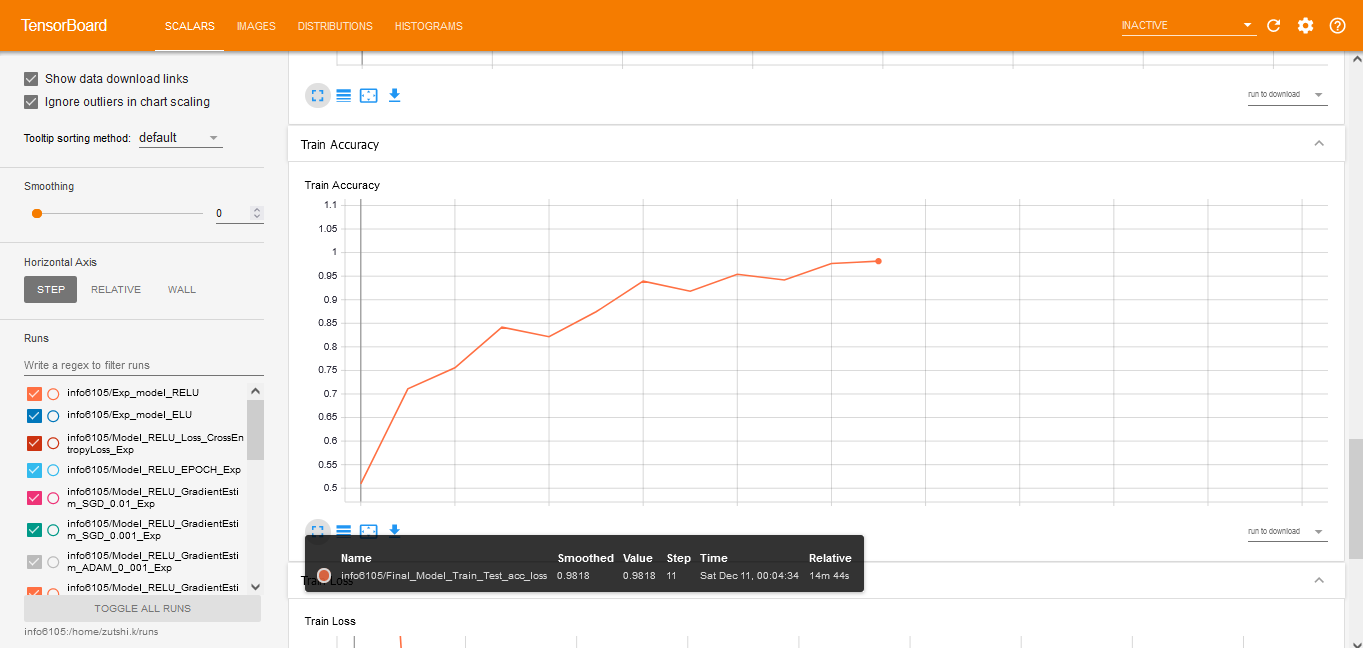
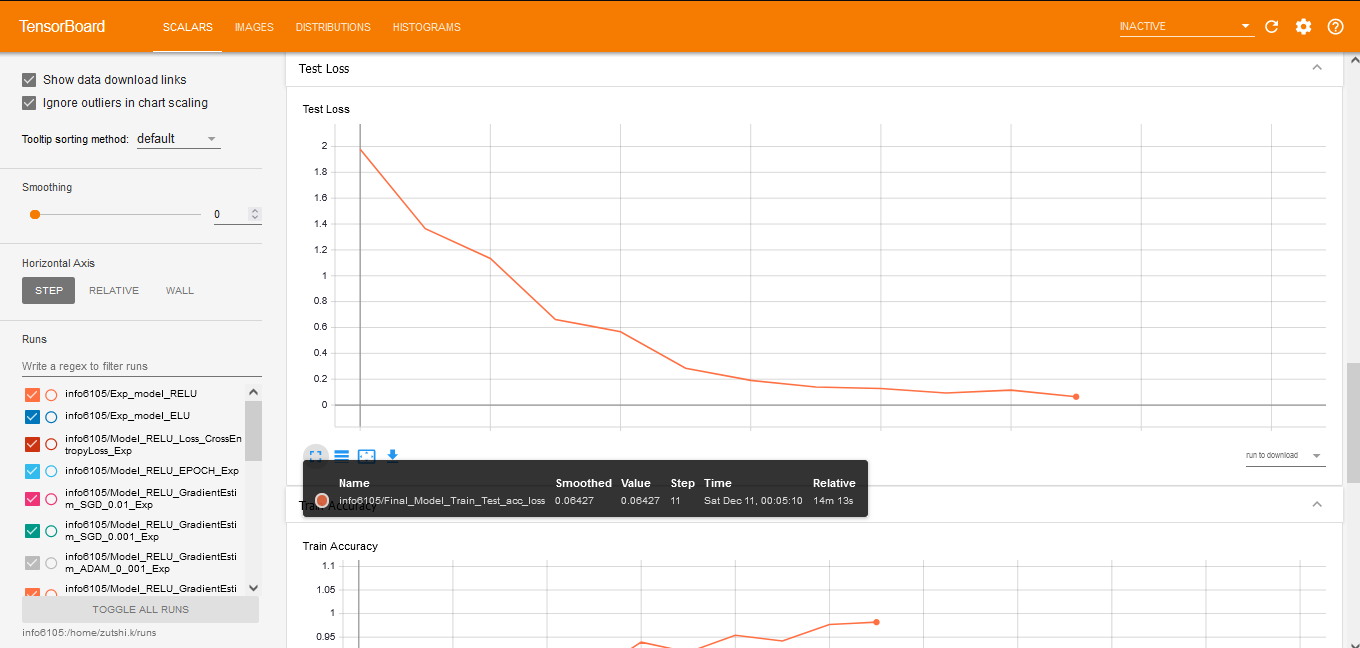

#### Test Accuracy and Test Loss
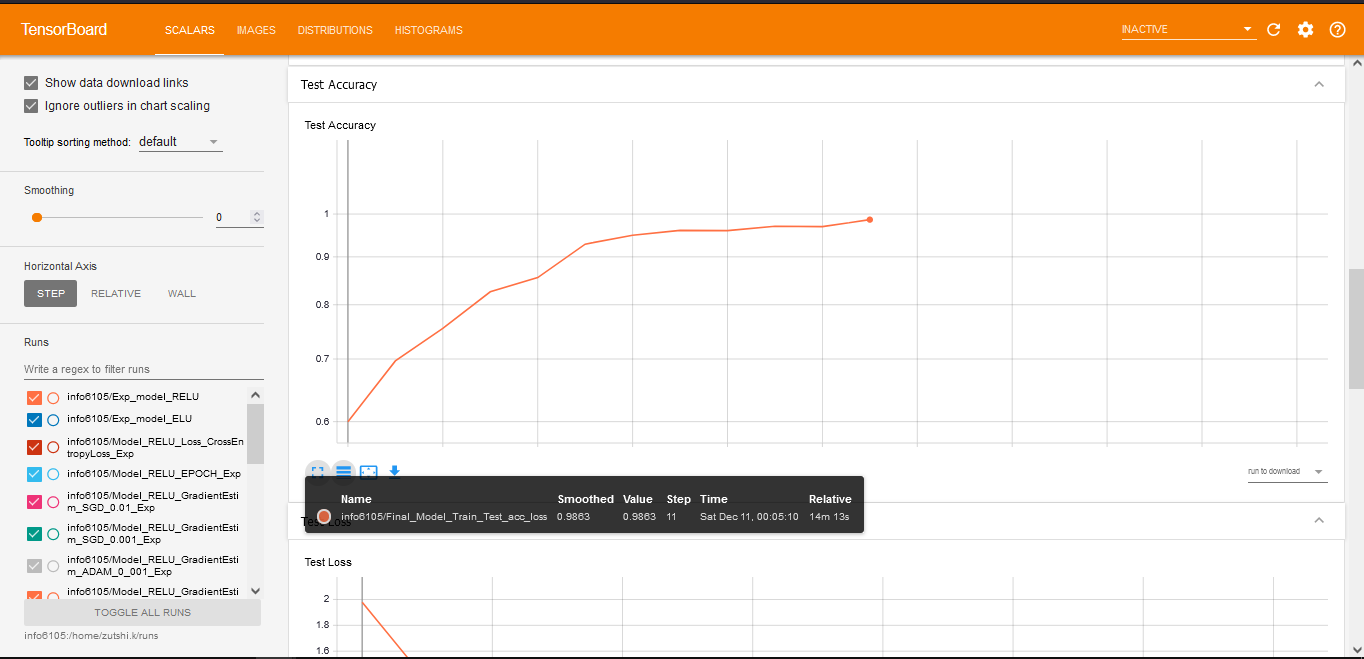
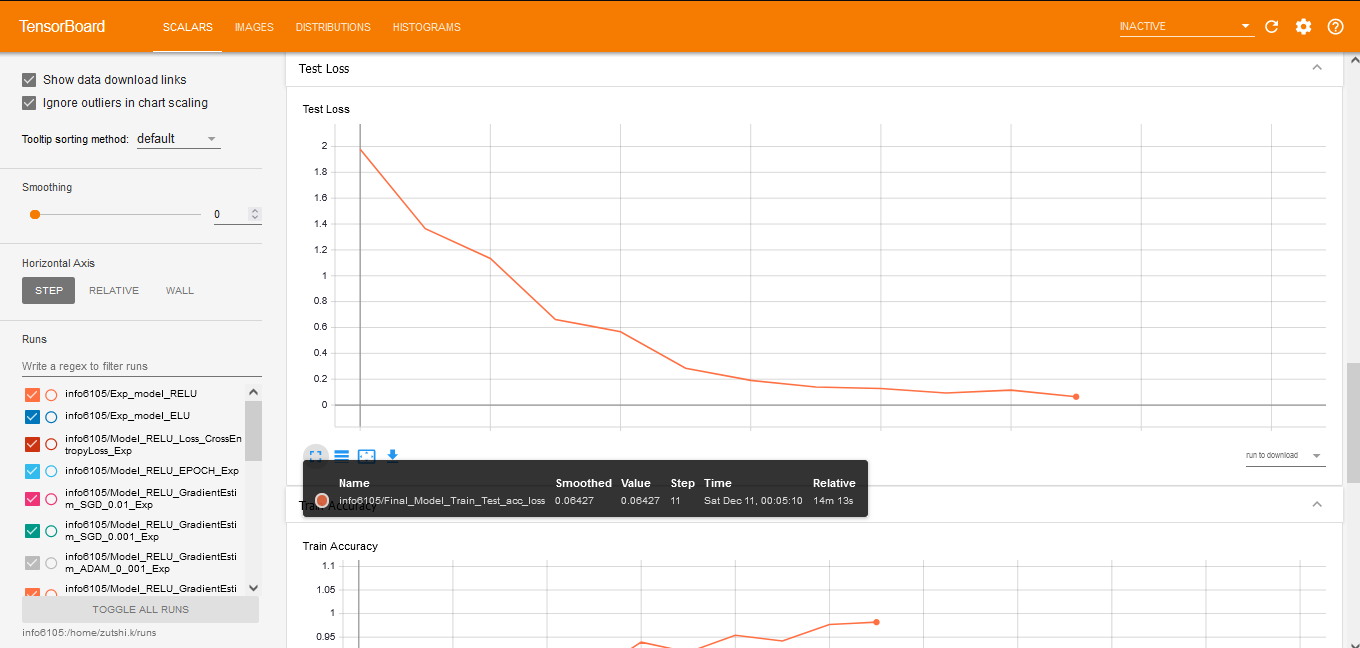

In [30]:
#Save the best model
torch.save(model.state_dict(),'best_checkpoint.model')

### Conclusion 📖

The initial Exploratory Data analysis of the dataset revealed a balanced ratio of all 6 image classes, both in train and test dataset. In approaching the Image classification, various parameters of the CNN model were changed in order to see the changes in accuracy and loss. 

The following affects were observed and ploted in Tensorbaord - 

- Affect of Activation Function - RELU and ELU
- Affect of Cost functions - CrossEntropy and Negative Log Loss(NLL)
- Affect of Epochs - Ranging from 0 to 15
- Affect of Gradient estimation and their corresponding learning Rates - Adam and SGD
- Affect of Network Architecture - Adding and remove Hidden layers from the CNN network
- Affect of Network Weight Initializations - Using Kaiming He uniform and Xavier Uniform


### Licensing & Citation 📰

Copyright 2021 Kshitij Zutshi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.




#### Citation Reference -


https://pytorch.org/vision/stable/models.html

Image classification using CNN from scratch in Pytorch Part I and II

https://www.youtube.com/watch?v=9OHlgDjaE2I

https://www.youtube.com/watch?v=zwHSQrNVNNE

Image Classification with Convolutional Neural Networks | Deep Learning with PyTorch: Zero to GANs

https://www.youtube.com/watch?v=d9QHNkD_Pos&t=234s

https://thevatsalsaglani.medium.com/multi-class-image-classification-using-cnn-over-pytorch-and-the-basics-of-cnn-fdf425a11dc0

TENSORBOARD PYTORCH Reference - 

https://towardsdatascience.com/a-complete-guide-to-using-tensorboard-with-pytorch-53cb2301e8c3
https://github.com/ajinkya98/TensorBoard_PyTorch/blob/master/model.py
https://towardsdatascience.com/pytorch-performance-analysis-with-tensorboard-7c61f91071aa
https://cnvrg.io/tensorboard-guide/